In [66]:
from utils_clustering import *
from utils_survival import *
from utils_evaluation import *
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold



# Load data
  

test_data = pd.read_csv('aml original data/clinical_test.csv', delimiter=',')
train_data = pd.read_csv('aml original data/clinical_train.csv', delimiter=',')
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
directory ='GEN/Results/survival'
stage = 'wo_Stage'
thresh = 't = 0.02'



if not os.path.exists(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv'):
    clinical_data = pd.read_csv('aml original data/AML_clinic.csv', delimiter=',')
else:
    clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')



# create paths for saving results
if not os.path.exists(directory + '/' + thresh + '/'):
    os.makedirs(directory + '/' + thresh + '/')
if not os.path.exists(directory + '/' + thresh + '/KM/'):
    os.makedirs(directory + '/' + thresh + '/KM/')
if not os.path.exists(directory + '/' + thresh + '/KM/KM train/'):
    os.makedirs(directory + '/' + thresh + '/KM/KM train/')
if not os.path.exists(directory + '/' + thresh + '/KM/KM test/'):
    os.makedirs(directory + '/' + thresh + '/KM/KM test/')
if not os.path.exists(directory + '/' + thresh + '/' + stage + '/'):
    os.makedirs(directory + '/' + thresh + '/' + stage + '/')
if not os.path.exists(directory + '/' + thresh + '/' + stage + '/KM PI/'):
    os.makedirs(directory + '/' + thresh + '/' + stage + '/KM PI/')
if not os.path.exists(directory + '/' + thresh + '/opt/'):
    os.makedirs(directory + '/' + thresh + '/opt/')

### Train and Test generation

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
#train and test dataset 80% and 20% respectively
clinical_data = pd.read_csv('aml original data/AML_clinic.csv', delimiter=',')
new = clinical_data.copy()
y = new[['VitalStatus']]
X = new.drop(['VitalStatus'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42
                                                    , stratify=y)

# merge train and test data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('aml original data/clinical_train.csv', index=False)
test_data.to_csv('aml original data/clinical_test.csv', index=False)

In [ ]:
# 10 folds from stratified k fold

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
cd_train = pd.read_csv('aml original data/clinical_train.csv', delimiter=',')

#apply stratified k fold
train = cd_train.copy()

y = cd_train[['VitalStatus']]

X = train.drop(['VitalStatus'], axis=1)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    train_data = train.iloc[train_index]
    train_data.to_csv('aml original data/clinical_train_fold' + str(i) + '.csv', index=False)


### ADD GENOTYPE

In [1]:

with open("tree_map.pickle", "rb") as f:
    tree_map = pickle.load(f)

print(tree_map)

FileNotFoundError: [Errno 2] No such file or directory: 'tree_map_analysis.pickle'

In [ ]:
from anytree import Node, RenderTree

for j, k in tree_map.items():
    for i in k.values():
        print(RenderTree(i))

In [ ]:
clinical_data = pd.read_csv('Results/survival' + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
clinical_data.set_index('sample', inplace=True)

In [ ]:
# Step 1: Extract Mutation Names
from anytree import PreOrderIter

all_mutations = set()
for sample, trees in tree_map.items():
    for tree_id, tree in trees.items():
        for node in PreOrderIter(tree):  # Traverse tree
            all_mutations.add(node.matching_label)  # or node.label

# Step 2: Update Dataset
for mutation in all_mutations:
    clinical_data[mutation] = 0  # Add a column for each mutation with initial value 0

# Step 3 & 4: Traverse Trees and Update Dataset
for sample, trees in tree_map.items():
    for tree_id, tree in trees.items():
        for node in PreOrderIter(tree):  # Traverse tree
            mutation = node.matching_label  # or node.label
            if mutation in clinical_data.columns:
                clinical_data.loc[sample, mutation] = 1  # Update dataset

clinical_data

In [ ]:
#drop column 'Root' from clinical_data

clinical_data.drop('Root', axis=1)
clinical_data

In [ ]:
all_mutations.discard('Root')
list_mut = list(all_mutations)
print(list_mut)

In [ ]:
clinical_data.reset_index(inplace=True)
clinical_data

In [ ]:
clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)

In [ ]:
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')

clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Dead NOS',1)
clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Alive NOS',0)

clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

### CHOOSE GENES

In [ ]:
genome = ['EZH2', 'GATA2', 'TP53', 'STAG2', 'IDH1', 'ETV6', 'SRSF2', 'U2AF1', 'DNMT3A', 'SF3B1', 'FLT3', 'PTPN11', 'NRAS', 'CSF3R', 'IDH2', 'PPM1D', 'CBL', 'MYC', 'KRAS', 'KIT', 'PHF6', 'SMC3', 'ASXL1', 'BCOR', 'SETBP1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3-ITD', 'JAK2']

# Placeholder DataFrame for the counts
gene_counts = pd.DataFrame(columns=['gene', 'count_0', 'count_1'])

# Assuming cd_train is your data
# ...

for gene in genome:
    counts = cd_train[gene].value_counts()
    gene_counts = gene_counts.append({
        'gene': gene,
        'count_0': counts.get(0, 0),  # get() returns 0 if the key is not found
        'count_1': counts.get(1, 0)
    }, ignore_index=True)

# Display the DataFrame
print(gene_counts)

In [ ]:
# Filter genes to ensure at least 20% representation in both categories
filtered_genes = gene_counts[
    (gene_counts['count_1'] >= 0.10 * (gene_counts['count_1'] + gene_counts['count_0'])) &
    (gene_counts['count_0'] >= 0.10 * (gene_counts['count_1'] + gene_counts['count_0']))
]

# Display the filtered DataFrame
print(filtered_genes)

In [ ]:
filtered_genes.to_csv(directory +  '/' + thresh + "/covariates_gene.csv", index = False)

In [21]:
filtered_genes = pd.read_csv(directory +  '/' + thresh + "/covariates_gene.csv", delimiter=',')
genome = list(filtered_genes['gene'])

In [46]:
clinical_data = pd.read_csv(directory + '/t = 0.02/clinicaldata_wclusterlabels.csv', delimiter=',')

In [49]:
nclusters = pd.read_csv('Results/Threshold_nclust.csv', index_col=0)
n_1 = list(nclusters['t=0.01'].values)

for i in range(len(methods)):
    method = methods[i]

    n_clust = n_1[i]

    X = pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=',')

    labels = get_cluster_labels(X, n_clust)

    clinical_data[method] = labels

clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)


### DIFFERENTIAL EVOLUTION

#### CHOOSE BEST WEIGHTS

In [35]:
import re

# Initialize the list to store the extracted information
weights_aic_list = []
file_path = 'GEN/Results/Diff Ev Results/diff_ev_gen_cv.txt'
pattern = re.compile(r"[-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?")

# Open the file and read line by line
with open(file_path, 'r') as file:
    while True:
        weights_str_list = []
        
        # Concatenate lines until a valid array of weights is formed
        while True:
            # Read the next line
            line = file.readline().strip()
            
            # Check if we have reached the end of the file
            if not line:
                break
            
            # Use regex to find all floating point numbers in the string
            weights_str_list.extend(pattern.findall(line))
            
            # If the line does not end with a ']' it means the array continues in the next line
            if line.endswith(']'):
                break
        
        # Check if we have reached the end of the file
        if not weights_str_list:
            break
        
        # Convert the string numbers to floats and create a list of weights
        weights = [float(weight) for weight in weights_str_list]
        
        # Read the AIC value line
        aic_line = file.readline().strip()
        
        # Check if we have reached the end of the file
        if not aic_line:
            break
        
        # Convert the string representation of the AIC value to a float
        try:
            aic = float(aic_line)
            # Store the extracted information in the list
            weights_aic_list.append((aic, weights))
        except ValueError:
            # If conversion to float fails, continue to the next pair
            print(f'Failed to convert AIC value {aic_line} to float')
            continue

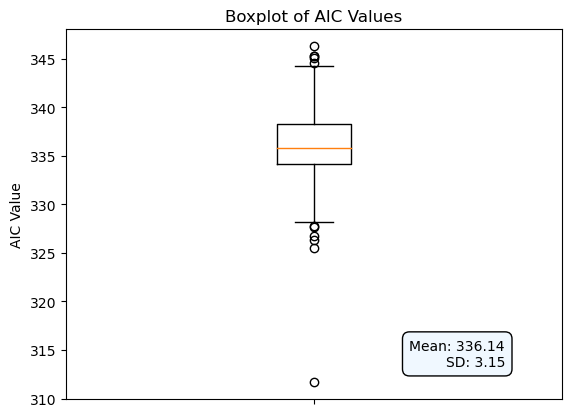

In [36]:
import matplotlib.pyplot as plt

# Extract the AIC values from the list of tuples
aic_values = [aic for aic, _ in weights_aic_list]


# Create a boxplot for the AIC values
plt.boxplot(aic_values)

mean = np.mean(aic_values)
std_dev = np.std(aic_values)

# Add title and labels
plt.title('Boxplot of AIC Values')
plt.ylabel('AIC Value')
plt.annotate(
    f'Mean: {mean:.2f}\nSD: {std_dev:.2f}',
    xy=(0.8, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='aliceblue')
)

ax = plt.gca()
ax.set_xticklabels([])
# Show the plot
plt.show()


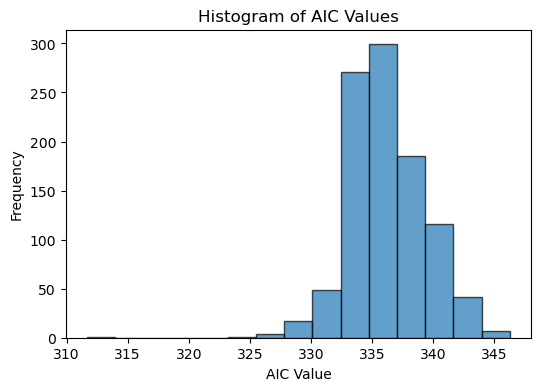

In [37]:
# Create a histogram for the AIC values with 10 bins
plt.figure(figsize=(6,4))
plt.hist(aic_values, bins=15, edgecolor='k', alpha=0.7)

# Add title and labels
plt.title('Histogram of AIC Values')
plt.xlabel('AIC Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

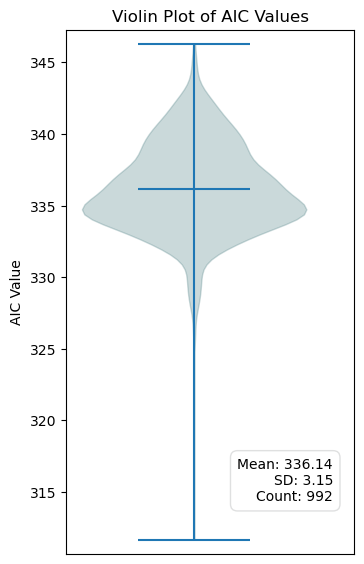

In [38]:
# Define the color for the violin plot
color = '#528387'

# Create a violin plot for the AIC values
plt.figure(figsize=(4, 6))
plt.violinplot(aic_values, showmeans=True, vert=True, widths=0.7)

# Customize the color of the violin plot
plt.gca().collections[0].set_facecolor(color)
plt.gca().collections[0].set_edgecolor(color)

# Add title and labels
plt.title('Violin Plot of AIC Values')
plt.ylabel('AIC Value')

# Remove the x-axis tick labels
plt.gca().set_xticks([])

plt.ylim(min(aic_values) - 1, max(aic_values) + 1)
plt.xlim(0.6,1.5)

mean = np.mean(aic_values)
std_dev = np.std(aic_values)

plt.tight_layout(pad=2)
plt.annotate(
    f'Mean: {mean:.2f}\nSD: {std_dev:.2f}\nCount: {len(aic_values)}',
    xy=(0.85, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='#D2D3D4', facecolor='white', alpha=0.7)
)
# Show the plot
plt.show()

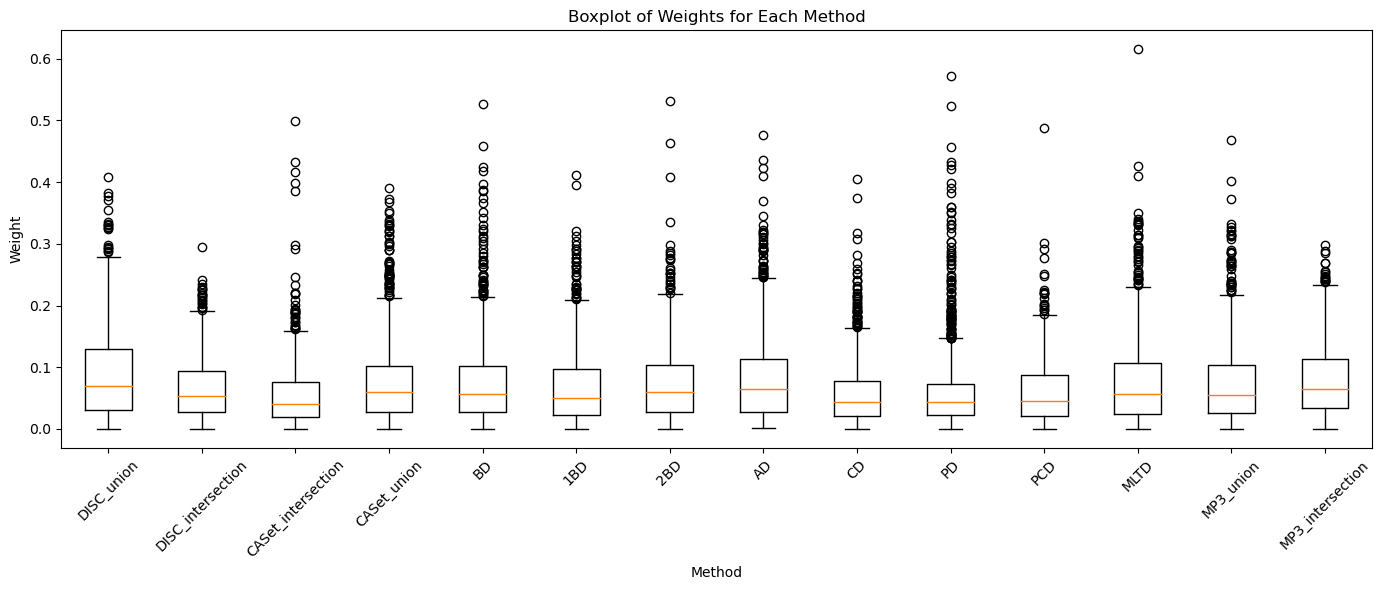

In [41]:
# Initialize a dictionary to store the weights for each method
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']

weights_by_method = {method: [] for method in methods}

# Iterate through the list of weights and AIC values and extract the weights for each method
for idx, (aic, weights) in enumerate(weights_aic_list):
    if len(weights) != len(methods):
        # Print a warning message if the number of weights does not match the number of methods
        print(f"Warning: Number of weights ({len(weights)}) does not match number of methods ({len(methods)}) at index {idx}.")
        continue
    
    for i, weight in enumerate(weights):
        method = methods[i]
        weights_by_method[method].append(weight)

# Create a list of weights for each method in the order of methods
weights_data = [weights_by_method[method] for method in methods]

# Create a boxplot for each method
plt.figure(figsize=(14, 6))
plt.boxplot(weights_data, labels=methods)

# Add title and labels
plt.title('Boxplot of Weights for Each Method')
plt.xlabel('Method')
plt.ylabel('Weight')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

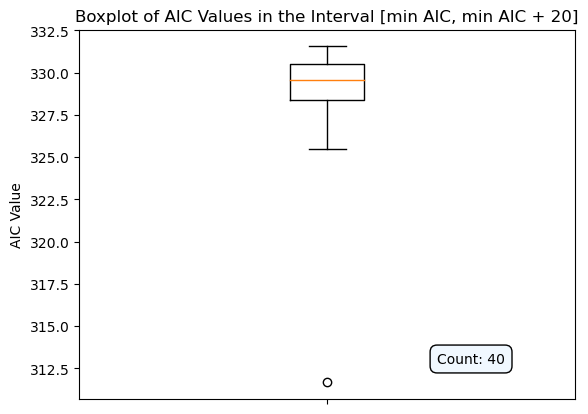

In [42]:
# Create a boxplot for the filtered AIC values
min_aic = min(aic_values)

d = 20
# Define the upper bound of the interval
upper_bound = min_aic + d

# Filter the AIC values that are in the interval [min_aic, min_aic + 5]
filtered_aic_values = [aic for aic in aic_values if aic <= upper_bound]

num_aic_in_interval = len(filtered_aic_values)

plt.boxplot(filtered_aic_values)

# Add title and labels
plt.title(f'Boxplot of AIC Values in the Interval [min AIC, min AIC + {d}]')
plt.ylabel('AIC Value')

# Add the number of AIC values in the interval as text to the plot
plt.annotate(
    f'Count: {num_aic_in_interval}',
    xy=(0.8, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='aliceblue')
)


# Remove the x-axis tick labels
ax = plt.gca()
ax.set_xticklabels([])

# Show the plot
plt.show()

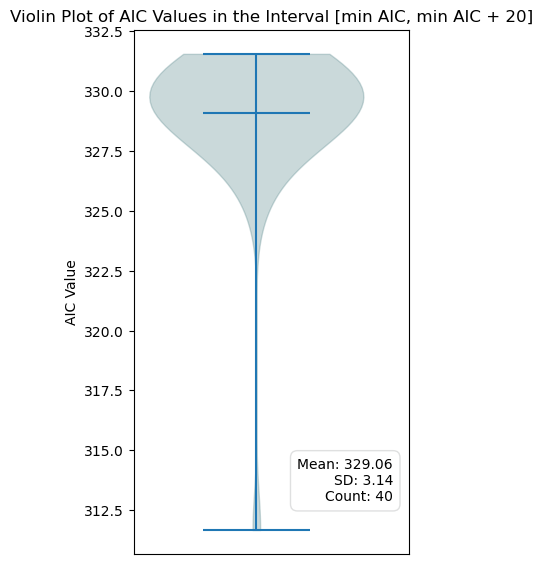

In [43]:
# Define the color for the violin plot
color = '#528387'

# Create a violin plot for the AIC values
plt.figure(figsize=(4, 6))
plt.violinplot(filtered_aic_values, showmeans=True, vert=True, widths=0.7)

# Customize the color of the violin plot
plt.gca().collections[0].set_facecolor(color)
plt.gca().collections[0].set_edgecolor(color)

# Add title and labels
plt.title(f'Violin Plot of AIC Values in the Interval [min AIC, min AIC + {d}]')
plt.ylabel('AIC Value')

# Remove the x-axis tick labels
plt.gca().set_xticks([])

plt.ylim(min(filtered_aic_values) - 1, max(filtered_aic_values) + 1)
plt.xlim(0.6,1.5)

mean = np.mean(filtered_aic_values)
std_dev = np.std(filtered_aic_values)

plt.tight_layout(pad=2)
plt.annotate(
    f'Mean: {mean:.2f}\nSD: {std_dev:.2f}\nCount: {num_aic_in_interval}',
    xy=(1, 0.1), xycoords='figure fraction',
    xytext=(-5, 0), textcoords='offset points',
    
    ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='#D2D3D4', facecolor='white', alpha=0.7)
)
# Show the plot
plt.show()

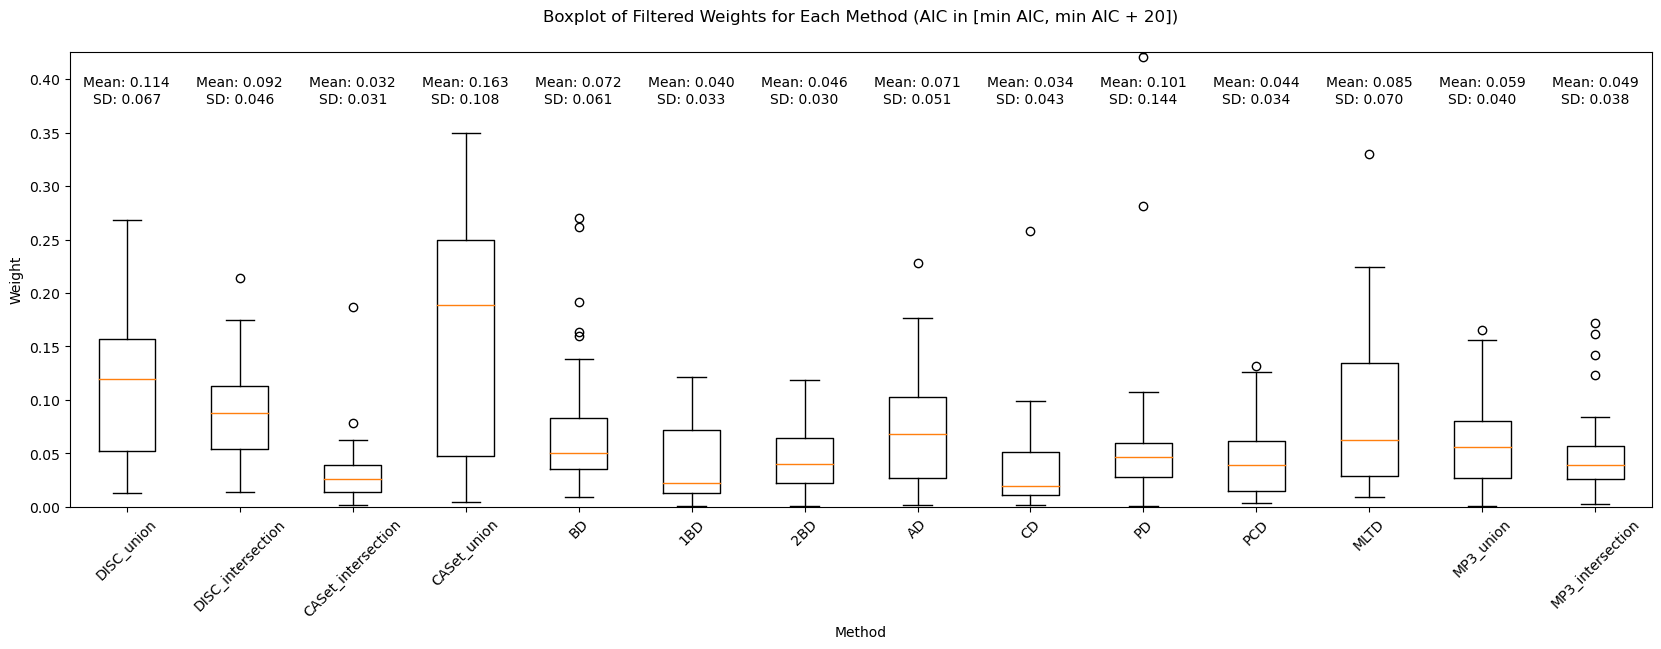

In [44]:
# Filter the list of weights and AIC values based on the specified interval
filtered_weights_aic_list = [(aic, weights) for aic, weights in weights_aic_list if aic <= upper_bound]

# Initialize a dictionary to store the filtered weights for each method
filtered_weights_by_method = {method: [] for method in methods}

# Iterate through the filtered list and extract the weights for each method
for aic, weights in filtered_weights_aic_list:
    for i, weight in enumerate(weights):
        method = methods[i]
        filtered_weights_by_method[method].append(weight)

# Create a list of filtered weights for each method in the order of methods
filtered_weights_data = [filtered_weights_by_method[method] for method in methods]

# Create a boxplot for each method using the filtered weights
plt.figure(figsize=(14, 6))
bp = plt.boxplot(filtered_weights_data, labels=methods)

# Add title with adjusted vertical position and labels
plt.title(f'Boxplot of Filtered Weights for Each Method (AIC in [min AIC, min AIC + {d}])', y=1.05)
plt.xlabel('Method')
plt.ylabel('Weight')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Calculate the position above each box to place the annotation
y_max = max([item.get_ydata().max() for item in bp['boxes']])
annotation_height = y_max + (y_max * 0.5)  # 10% above the highest box

# Iterate through the filtered weights for each method and annotate the mean and standard deviation
for i, weights in enumerate(filtered_weights_data):
    mean = np.mean(weights)
    std_dev = np.std(weights)
    plt.annotate(
        f'Mean: {mean:.3f}\nSD: {std_dev:.3f}',
        xy=(i + 1, annotation_height),
        xycoords='data',
        xytext=(0, 0),
        textcoords='offset points',
        ha='center',
        va='bottom',
        rotation=0
    )

# Adjust the y-axis limit to fit the annotations
plt.ylim(0, annotation_height + (y_max * 0.2))

# Show the plot with adjusted layout
plt.tight_layout(rect=[0, 0, 1.2, 1.1])
plt.show()

In [14]:
def get_lowest_aic(data):
    # Sort by AIC value
    sorted_data = sorted(data, key=lambda x: x[0])

    # Return the top 3 (lowest AICs)
    return sorted_data[:3]


lowest_aic_values = get_lowest_aic(weights_aic_list)

for weights, aic in lowest_aic_values:
    print("Weights:", weights)
    print("AIC:", aic)
    print("------")

Weights: 311.6734342031027
AIC: [0.02733794, 0.07469928, 0.02926663, 0.04810693, 0.00887947, 0.00534532, 0.05919299, 0.03553525, 0.01256858, 0.57178592, 0.04220604, 0.00893674, 0.05745045, 0.01868845]
------
Weights: 325.47872287265534
AIC: [0.05765877, 0.21421826, 0.00794646, 0.01922582, 0.03626721, 0.01520608, 0.00681902, 0.0208668, 0.00749342, 0.42778623, 0.10178157, 0.01125268, 0.00811841, 0.06535929]
------
Weights: 326.3261866090238
AIC: [0.05294268, 0.05169661, 0.18657213, 0.01886809, 0.27033755, 0.01407577, 0.01905011, 0.00631384, 0.02374352, 0.28131536, 0.01435469, 0.0090729, 0.04786701, 0.00378974]
------


In [15]:
r_lowest_aic_values = []
weights = lowest_aic_values[0][1]
aic = lowest_aic_values[0][0]
print("Weights:", weights)
print("AIC:", aic)

Weights: [0.02733794, 0.07469928, 0.02926663, 0.04810693, 0.00887947, 0.00534532, 0.05919299, 0.03553525, 0.01256858, 0.57178592, 0.04220604, 0.00893674, 0.05745045, 0.01868845]
AIC: 311.6734342031027


In [19]:
weights_round = [round(weight, 2) for weight in weights]
print(weights_round)

weights_round = [0.03, 0.07, 0.03, 0.05, 0.01, 0.01, 0.06, 0.04, 0.01, 0.57, 0.04, 0.01, 0.06, 0.01]
print(sum(weights_round))
# i want to input as the weights the weights_round
r_lowest_aic_values += [(weights_round, aic)]

[0.03, 0.07, 0.03, 0.05, 0.01, 0.01, 0.06, 0.04, 0.01, 0.57, 0.04, 0.01, 0.06, 0.02]
1.0


In [20]:
weights = lowest_aic_values[1][1]
aic = lowest_aic_values[1][0]
print("Weights:", weights)
print("AIC:", aic)

Weights: [0.05765877, 0.21421826, 0.00794646, 0.01922582, 0.03626721, 0.01520608, 0.00681902, 0.0208668, 0.00749342, 0.42778623, 0.10178157, 0.01125268, 0.00811841, 0.06535929]
AIC: 325.47872287265534


In [23]:
weights_round = [round(weight, 2) for weight in weights]
print(weights_round)

weights_round = [0.06, 0.21, 0.01, 0.02, 0.04, 0.01, 0.01, 0.01, 0.01, 0.43, 0.1, 0.01, 0.01, 0.07]
print(sum(weights_round))
# i want to input as the weights the weights_round
r_lowest_aic_values += [(weights_round, aic)]

[0.06, 0.21, 0.01, 0.02, 0.04, 0.02, 0.01, 0.02, 0.01, 0.43, 0.1, 0.01, 0.01, 0.07]
1.0


In [24]:
weights = lowest_aic_values[2][1]
aic = lowest_aic_values[2][0]
print("Weights:", weights)
print("AIC:", aic)

Weights: [0.05294268, 0.05169661, 0.18657213, 0.01886809, 0.27033755, 0.01407577, 0.01905011, 0.00631384, 0.02374352, 0.28131536, 0.01435469, 0.0090729, 0.04786701, 0.00378974]
AIC: 326.3261866090238


In [28]:
weights_round = [round(weight, 2) for weight in weights]
print(weights_round)

weights_round = [0.05, 0.05, 0.19, 0.02, 0.28, 0.01, 0.02, 0.01, 0.02, 0.28, 0.01, 0.01, 0.05, 0]
print(sum(weights_round))
# i want to input as the weights the weights_round
r_lowest_aic_values += [(weights_round, aic)]

[0.05, 0.05, 0.19, 0.02, 0.27, 0.01, 0.02, 0.01, 0.02, 0.28, 0.01, 0.01, 0.05, 0.0]
1.0000000000000002


In [29]:
import plotly.graph_objects as go

# Define metrics
metrics = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']

# Create the radar chart
fig = go.Figure()

# Iterate over each set of weights in lowest_aic_values
for weights, aic in r_lowest_aic_values:
    # Complete the loop for plotting
    weights_circ = weights + weights[:1]

    fig.add_trace(go.Scatterpolar(
        r=weights_circ,
        theta=metrics + [metrics[0]], # complete the loop for the metrics as well
        fill='toself',
        name=f"AIC: {aic:.2f}"
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(weight for weights, _ in r_lowest_aic_values for weight in weights)] # corrected line
        )),
    showlegend=True
)

# Save as an HTML file
fig.write_html("radar_chart.html") 

# Show the plot
fig.show()

#### WEIGHT METHOD RESULT

In [30]:
weights = r_lowest_aic_values[0][0]


methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']

list_matrix =list()

for method in methods:
    list_matrix.append(pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=','))

matrix = np.zeros((len(list_matrix[0]), len(list_matrix[0])))

for n in range(len(list_matrix)):

    matrix += list_matrix[n] * weights[n]

In [31]:
matrix.to_csv('Matrix Output/AML_Optimal_Combination.csv', index=False)

In [32]:
np_matrix = matrix.to_numpy()
histograms(np_matrix, 'Results/survival/t = 0.02/opt/histogram_optimizer.png', 'Optimal Combination')

<Figure size 1000x1000 with 0 Axes>

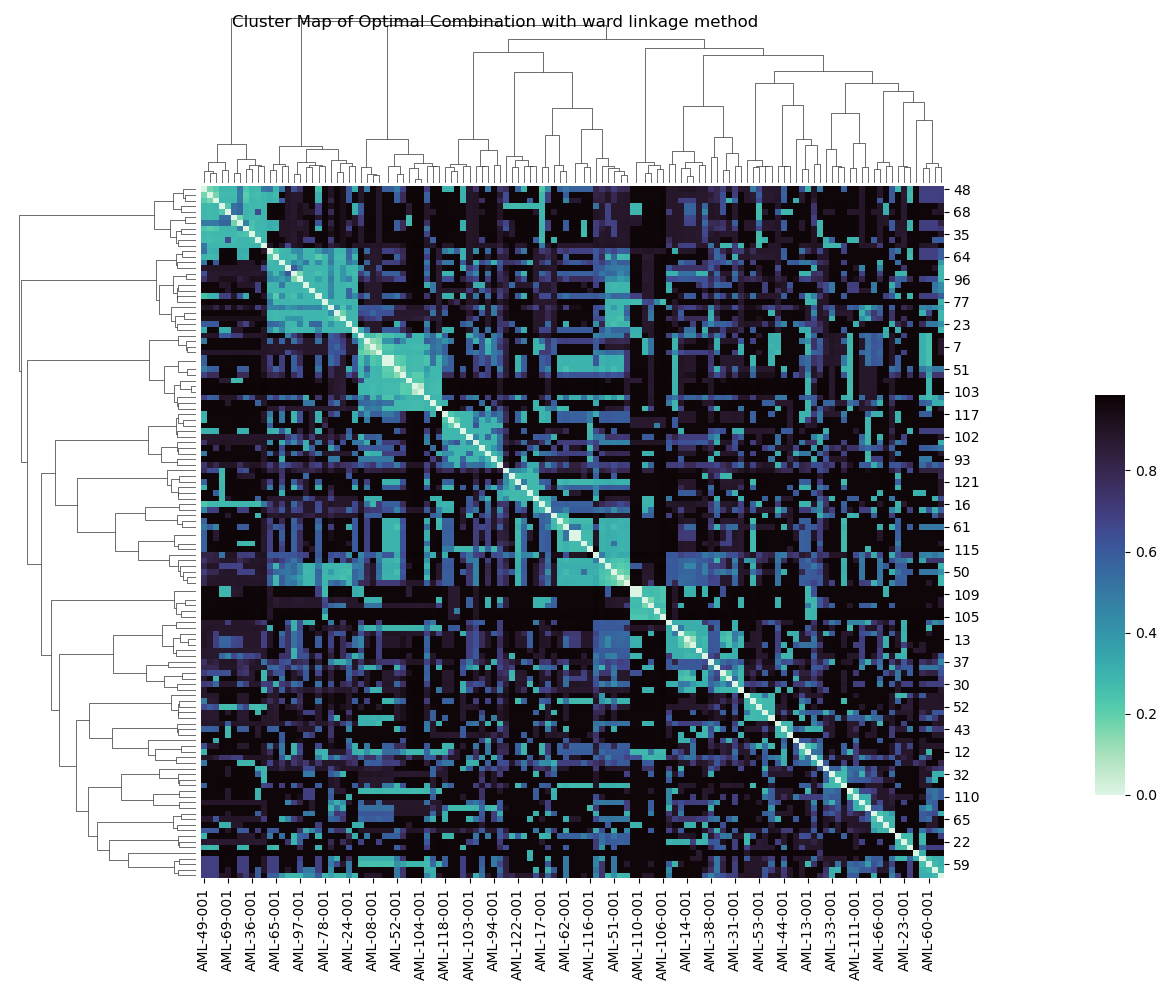

In [33]:
cluster_map('Optimal Combination', 'ward', matrix, 'Results/survival/t = 0.02/opt/clustermap_optimizer.png')

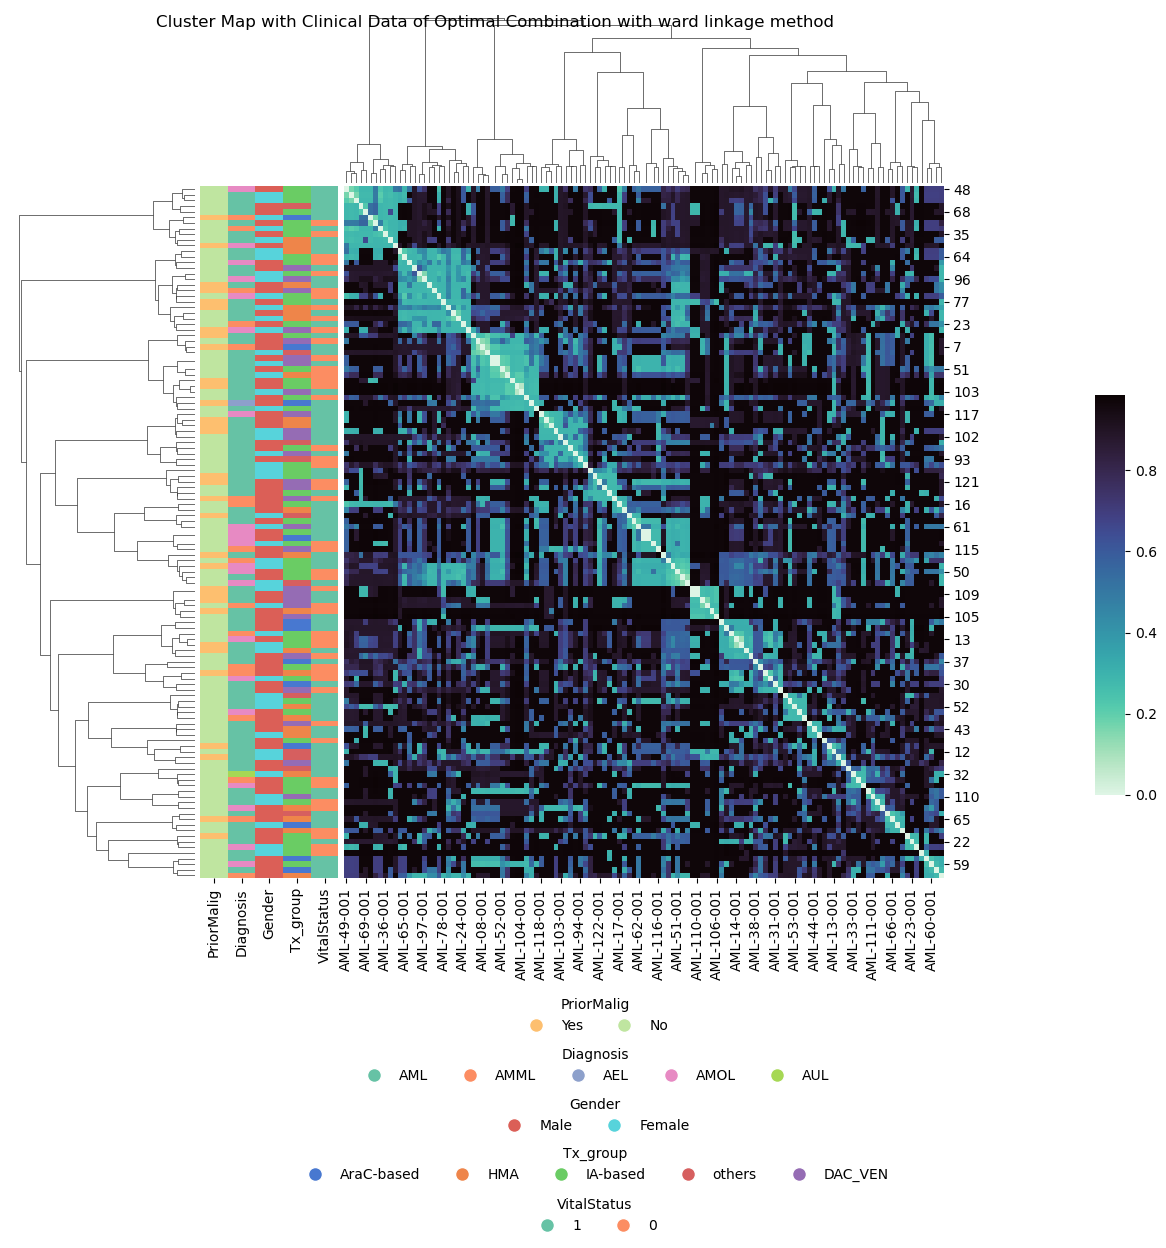

In [34]:
clustermap_wClinical_legend(matrix, 'Optimal Combination',clinical_data,'ward', 'Results/survival/t = 0.02/opt/clustermap_wClinical_optimizer.png')

### GROUP LASSO

In [22]:
#enconder dataset
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']
#methods2 = ['CASet_geometric','CASet_sigmoid','DISC_geometric','DISC_sigmoid']
#n_methods = methods + methods2
cd_train = pd.read_csv(directory + '/'+ thresh + '/clinicaldata_train.csv', delimiter=',')

datawclusters = pd.read_csv(directory + '/'+ thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')

#enconder dataset
cd_train_n = cd_train[['sample']]
cd_train_t = pd.merge(datawclusters, cd_train_n, on='sample', how='inner')
dfs = convert_to_category(cd_train_t,columns =['Gender'], method=methods)

filtered_df = filter_data(dfs, ['age','Gender', 'maxCCF'] +genome+ methods)

df_HE = convert_to_OneHotEncoder(filtered_df)

df_HE.to_csv(directory + '/' + thresh + f'/clinicaldata_train_HE.csv', index=False)


In [23]:
import re
df_HE = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train_HE.csv', delimiter=',')
columns = list(df_HE.columns)


# Extract group names using regex
group_names_list = []
for col in columns:
    match = re.match(r"([a-zA-Z0-9_]+)", col)
    if match:
        group_names_list.append(match.group(1))

print(tuple(group_names_list))


('age', 'Gender', 'maxCCF', 'TP53', 'IDH1', 'SRSF2', 'DNMT3A', 'FLT3', 'PTPN11', 'NRAS', 'IDH2', 'KRAS', 'ASXL1', 'TET2', 'NPM1', 'WT1', 'RUNX1', 'FLT3', 'DISC_union', 'DISC_union', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'DISC_intersection', 'CASet_intersection', 'CASet_intersection', 'CASet_intersection', 'CASet_union', 'CASet_union', 'BD', 'BD', '1BD', '1BD', '2BD', '2BD', 'AD', 'AD', 'CD', 'CD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PCD', 'PCD', 'MLTD', 'MLTD', 'MP3_union', 'MP3_union', 'MP3_intersection', 'MP3_intersection')


In [24]:
n_params_gl = len(group_names_list)
print(n_params_gl)

62


In [25]:
coef_gr = pd.read_csv('GEN/Results/survival/t = 0.02/R_coef.csv', delimiter=',')

for row in coef_gr.iterrows():

    print(row)

(0, Coefficients    0.0
Names           age
Name: 0, dtype: object)
(1, Coefficients            0.0
Names           Gender.Male
Name: 1, dtype: object)
(2, Coefficients    0.082167
Names             maxCCF
Name: 2, dtype: object)
(3, Coefficients    0.484658
Names               TP53
Name: 3, dtype: object)
(4, Coefficients     0.0
Names           IDH1
Name: 4, dtype: object)
(5, Coefficients      0.0
Names           SRSF2
Name: 5, dtype: object)
(6, Coefficients       0.0
Names           DNMT3A
Name: 6, dtype: object)
(7, Coefficients   -0.418441
Names               FLT3
Name: 7, dtype: object)
(8, Coefficients       0.0
Names           PTPN11
Name: 8, dtype: object)
(9, Coefficients     0.0
Names           NRAS
Name: 9, dtype: object)
(10, Coefficients     0.0
Names           IDH2
Name: 10, dtype: object)
(11, Coefficients     0.0
Names           KRAS
Name: 11, dtype: object)
(12, Coefficients      0.0
Names           ASXL1
Name: 12, dtype: object)
(13, Coefficients     0.0
Names     

In [26]:

onebd = 0.332262 + 0.374172


In [27]:
soma = onebd 

n_onebd = onebd/soma


In [28]:
import plotly.graph_objects as go

# Define metrics
metrics = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_intersection']


# Create the radar chart
fig = go.Figure()

aic = 374.74
weights = [0,0,0,0,0,n_onebd,0,0,0,0,0,0,0,0]

# Complete the loop for plotting
weights_circ = weights + weights[:1]

fig.add_trace(go.Scatterpolar(
    r=weights_circ,
    theta=metrics + [metrics[0]], # complete the loop for the metrics as well
    fill='toself',
    name=f"AIC: {aic:.2f}"
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(weight for weight in weights)] # corrected line
        )),
    showlegend=True
)

# Save as an HTML file
fig.write_html("gl_radar_chart.html") 

# Show the plot
fig.show()

### GET RESULTS


In [67]:
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
clinical_col = ['age','Gender','maxCCF']
filtered_genes = pd.read_csv(directory +  '/t = 0.02/covariates_gene.csv', delimiter=',')
gene = filtered_genes['gene'].tolist()

new = gene + clinical_col + methods

In [68]:
#merge clinical data with train and test data
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')

clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Dead NOS',1)
clinical_data['VitalStatus'] = clinical_data['VitalStatus'].replace('Alive NOS',0)

clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [69]:
#merge clinical data with train and test data
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
matrix = pd.read_csv('Matrix Output/AML_Optimal_Combination.csv', delimiter=',')
n_clust = get_n_clusters_simple(matrix)
labels = list(get_cluster_labels(matrix, n_clust))

# Add the cluster labels to the clinical data
clinical_data['Optimal Combination'] = labels
clinical_data.to_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', index=False)
train_data = train_data[['sample']]
test_data = test_data[['sample']]
cd_train = pd.merge(clinical_data, train_data, on='sample', how='inner')
cd_test = pd.merge(clinical_data, test_data, on='sample', how='inner')
cd_train.to_csv(directory + '/' + thresh + '/clinicaldata_train.csv', index=False)
cd_test.to_csv(directory + '/' + thresh + '/clinicaldata_test.csv', index=False)

In [70]:
### KM plots
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric','Optimal Combination']
clinical_col = ['age','Gender','maxCCF']
gene = filtered_genes['gene'].tolist()
combination = ['Optimal Combination','Group Lasso']


In [71]:
#### Cox regression LLR and AIC without CBL , BCOR , SMC3
dfs = convert_to_category(cd_train,columns =['Gender'], method=methods)
results = {}
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric','Optimal Combination']

methods_cox = ['Only Clinical', 'Genotype'] + methods + ['Group Lasso']
params = dict()
for method in methods_cox:
    print(method)
    if method == 'Only Clinical':
        filtered_df = filter_data(dfs,clinical_col + ['Survival in days', 'VitalStatus'])
    elif method == 'Genotype':
        filtered_df = filter_data(dfs,clinical_col + gene + ['Survival in days', 'VitalStatus'])
    elif method == 'Group Lasso':
        filtered_df = filter_data(dfs,['maxCCF','FLT3','FLT3-ITD','NPM1','TP53','1BD','Survival in days', 'VitalStatus'])
    else:
        filtered_df = filter_data(dfs,clinical_col + gene + [method, 'Survival in days', 'VitalStatus'])

    df_HE = convert_to_OneHotEncoder(filtered_df)
    cph_model = fit_cox_model(df_HE, 'Survival in days', 'VitalStatus')
    results[method] = {}
    results[method]['AIC'] = round(partial_AIC(cph_model),1)
    results[method]['Log-Likelihood'] = round(Log_Likelihood(cph_model),1)
    cph_model.print_summary()
    params[method] = cph_model.params_.shape[0]


results = pd.DataFrame(results).T
results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
results 

Only Clinical


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -191.00
         time fit was run = 2023-10-23 22:16:23 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.02       1.02       0.01             0.00             0.05                 1.00                 1.05
Gender=Male  -0.15       0.86       0.29            -0.72             0.41                 0.49                 1.51
maxCCF        1.72       5.58       0.88            -0.00             3.44                 1.00                31.30

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  2.13 0.03       4.92
Gender=Male     0.00 -0.53 0.60       0.74
maxCCF          0.00  1.95 0.05       4.30
---
Concordance = 0.56
Partial AIC = 388.00
log-likelihood ratio test = 7.34 on 3 df
-log2(p) of ll-ratio test = 4.02

Genotype


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -179.08
         time fit was run = 2023-10-23 22:16:23 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.05                 1.00                 1.06
Gender=Male   0.17       1.19       0.37            -0.56             0.90                 0.57                 2.46
maxCCF        1.38       3.96       1.15            -0.87             3.62                 0.42                37.48
TP53          1.02       2.77       0.46             0.11             1.93                 1.12                 6.86
IDH1          0.11       1.12       0.48            -0.83             1.05                 0.44                 2.84
SRSF2        -0.88       0.41       0.56            -1.98             0.21                 0.14                 1.24
DNMT3A        0.03       1.03       0.34            -0.63             0.69                 0.53                 2.00
FLT3         -1.01       0.36       0.55            -2.09             0.06                 0.12                 1.06
PTPN11        0.71       2.04       0.54            -0.34             1.77                 0.71                 5.85
NRAS         -0.37       0.69       0.40            -1.16             0.42                 0.31                 1.52
IDH2         -0.48       0.62       0.38            -1.23             0.26                 0.29                 1.30
KRAS          0.13       1.14       0.51            -0.87             1.12                 0.42                 3.07
ASXL1        -0.08       0.92       0.69            -1.43             1.26                 0.24                 3.54
TET2         -0.13       0.88       0.50            -1.11             0.85                 0.33                 2.35
NPM1         -1.05       0.35       0.38            -1.79            -0.30                 0.17                 0.74
WT1           0.13       1.14       0.44            -0.73             0.98                 0.48                 2.66
RUNX1        -0.25       0.78       0.50            -1.24             0.73                 0.29                 2.08
FLT3-ITD      0.48       1.62       0.35            -0.21             1.17                 0.81                 3.24

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.88 0.06       4.04
Gender=Male     0.00  0.46 0.65       0.63
maxCCF          0.00  1.20 0.23       2.12
TP53            0.00  2.20 0.03       5.15
IDH1            0.00  0.23 0.82       0.29
SRSF2           0.00 -1.58 0.11       3.13
DNMT3A          0.00  0.09 0.92       0.11
FLT3            0.00 -1.85 0.06       3.95
PTPN11          0.00  1.33 0.18       2.44
NRAS            0.00 -0.92 0.36       1.49
IDH2            0.00 -1.27 0.20       2.30
KRAS            0.00  0.25 0.80       0.32
ASXL1           0.00 -0.12 0.91       0.14
TET2            0.00 -0.25 0.80       0.32
NPM1            0.00 -2.76 0.01       7.43
WT1             0.00  0.29 0.77       0.38
RUNX1           0.00 -0.50 0.61       0.70
FLT3-ITD        0.00  1.35 0.18       2.51
---
Concordance = 0.72
Partial AIC = 394.16
log-likelihood ratio test = 31.19 on 18 df
-log2(p) of ll-ratio test = 5.19

DISC_union


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -179.04
         time fit was run = 2023-10-23 22:16:23 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
age            0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male    0.19       1.21       0.38            -0.55             0.92                 0.58                 2.52
maxCCF         1.41       4.09       1.17            -0.88             3.70                 0.41                40.42
TP53           0.96       2.61       0.53            -0.08             2.00                 0.93                 7.37
IDH1           0.09       1.09       0.49            -0.87             1.04                 0.42                 2.83
SRSF2         -0.91       0.40       0.57            -2.03             0.20                 0.13                 1.23
DNMT3A         0.05       1.05       0.34            -0.62             0.71                 0.54                 2.04
FLT3          -1.02       0.36       0.55            -2.10             0.06                 0.12                 1.07
PTPN11         0.75       2.11       0.55            -0.34             1.83                 0.71                 6.23
NRAS          -0.30       0.74       0.49            -1.25             0.65                 0.29                 1.91
IDH2          -0.51       0.60       0.40            -1.29             0.27                 0.28                 1.32
KRAS           0.12       1.13       0.51            -0.88             1.13                 0.42                 3.09
ASXL1         -0.09       0.92       0.69            -1.44             1.26                 0.24                 3.54
TET2          -0.14       0.87       0.51            -1.13             0.85                 0.32                 2.35
NPM1          -1.06       0.35       0.45            -1.94            -0.17                 0.14                 0.84
WT1            0.12       1.12       0.48            -0.84             1.07                 0.43                 2.90
RUNX1         -0.29       0.74       0.54            -1.35             0.76                 0.26                 2.13
FLT3-ITD       0.49       1.63       0.36            -0.22             1.20                 0.80                 3.34
DISC_union=1   0.01       1.01       0.62            -1.21             1.23                 0.30                 3.41
DISC_union=2  -0.14       0.87       0.67            -1.44             1.17                 0.24                 3.22

               cmp to     z    p   -log2(p)
covariate                                  
age              0.00  1.81 0.07       3.83
Gender=Male      0.00  0.50 0.62       0.69
maxCCF           0.00  1.20 0.23       2.13
TP53             0.00  1.81 0.07       3.85
IDH1             0.00  0.18 0.86       0.22
SRSF2            0.00 -1.60 0.11       3.19
DNMT3A           0.00  0.13 0.89       0.16
FLT3             0.00 -1.85 0.06       3.94
PTPN11           0.00  1.35 0.18       2.49
NRAS             0.00 -0.63 0.53       0.91
IDH2             0.00 -1.27 0.20       2.30
KRAS             0.00  0.24 0.81       0.31
ASXL1            0.00 -0.13 0.90       0.15
TET2             0.00 -0.27 0.79       0.35
NPM1             0.00 -2.34 0.02       5.69
WT1              0.00  0.24 0.81       0.30
RUNX1            0.00 -0.55 0.58       0.78
FLT3-ITD         0.00  1.34 0.18       2.48
DISC_union=1     0.00  0.02 0.99       0.02
DISC_union=2     0.00 -0.20 0.84       0.25
---
Concordance = 0.72
Partial AIC = 398.09
log-likelihood ratio

DISC_intersection


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column TP53 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'TP53'].var())
>>> print(df.loc[~events, 'TP53'].var())

A very low variance means that the column TP53 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.446. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete 

<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -169.85
         time fit was run = 2023-10-23 22:16:23 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
age                    0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
Gender=Male            0.44       1.55       0.45            -0.45             1.32                 0.64                 3.75
maxCCF                 2.86      17.51       1.50            -0.08             5.80                 0.93               330.99
TP53                   0.98       2.67       0.66            -0.31             2.27                 0.73                 9.70
IDH1                   0.20       1.22       0.65            -1.09             1.48                 0.34                 4.37
SRSF2                 -1.77       0.17       1.03            -3.79             0.25                 0.02                 1.29
DNMT3A                 0.39       1.47       0.50            -0.59             1.36                 0.56                 3.91
FLT3                  -1.04       0.35       0.72            -2.45             0.36                 0.09                 1.44
PTPN11                 1.22       3.40       0.71            -0.16             2.61                 0.85                13.57
NRAS                  -0.76       0.47       0.57            -1.88             0.35                 0.15                 1.42
IDH2                   0.74       2.10       0.75            -0.72             2.21                 0.48                 9.10
KRAS                   0.78       2.18       0.59            -0.38             1.94                 0.69                 6.94
ASXL1                 -0.81       0.45       1.06            -2.88             1.27                 0.06                 3.55
TET2                 -19.09       0.00    3509.83         -6898.22          6860.05                 0.00                  inf
NPM1                  -1.03       0.36       0.45            -1.91            -0.16                 0.15                 0.85
WT1                    1.03       2.79       0.55            -0.05             2.11                 0.95                 8.21
RUNX1                 -0.02       0.98       0.59            -1.18             1.14                 0.31                 3.14
FLT3-ITD               0.62       1.86       0.50            -0.35             1.59                 0.70                 4.90
DISC_intersection=1   -1.14       0.32       0.96            -3.01             0.74                 0.05                 2.09
DISC_intersection=2   -0.32       0.73       1.44            -3.14             2.51                 0.04                12.34
DISC_intersection=3    0.04       1.04       0.88            -1.69             1.77                 0.18                 5.86
DISC_intersection=4   -2.09       0.12       1.05            -4.16            -0.03                 0.02                 0.97
DISC_intersection=5   -1.80       0.16       1.25            -4.25             0.64                 0.01                 1.90
DISC_intersection=6   -3.30       0.04       1.35            -5.95            -0.66                 0.00                 0.52
DISC_intersection=7    0.34       1.40       1.16            -1.94             2.62                 0.14                13.75
DISC_intersection=8   -0.91       0.40       1.18            -3.23             1.41                 0.04                 4.10
DISC_intersection=9    1.14       3.14       1.35            -1.51             3.79                 0

CASet_intersection


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.85
         time fit was run = 2023-10-23 22:16:24 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
age                    0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male            0.17       1.18       0.38            -0.57             0.91                 0.57                 2.48
maxCCF                 1.33       3.78       1.19            -1.00             3.66                 0.37                38.75
TP53                   0.89       2.45       0.52            -0.13             1.92                 0.87                 6.84
IDH1                  -0.05       0.96       0.53            -1.09             0.99                 0.34                 2.70
SRSF2                 -0.84       0.43       0.60            -2.02             0.34                 0.13                 1.41
DNMT3A                -0.02       0.98       0.36            -0.71             0.68                 0.49                 1.97
FLT3                  -0.99       0.37       0.56            -2.08             0.10                 0.12                 1.10
PTPN11                 0.76       2.14       0.54            -0.30             1.81                 0.74                 6.14
NRAS                  -0.29       0.75       0.42            -1.11             0.52                 0.33                 1.69
IDH2                  -0.42       0.66       0.42            -1.24             0.39                 0.29                 1.48
KRAS                   0.11       1.11       0.50            -0.88             1.10                 0.42                 2.99
ASXL1                 -0.08       0.92       0.69            -1.44             1.27                 0.24                 3.57
TET2                  -0.14       0.87       0.52            -1.15             0.87                 0.32                 2.39
NPM1                  -1.13       0.32       0.41            -1.92            -0.33                 0.15                 0.72
WT1                    0.11       1.12       0.45            -0.76             0.98                 0.47                 2.67
RUNX1                 -0.24       0.79       0.53            -1.28             0.80                 0.28                 2.23
FLT3-ITD               0.55       1.74       0.37            -0.18             1.29                 0.83                 3.62
CASet_intersection=1   0.01       1.01       0.50            -0.97             0.99                 0.38                 2.68
CASet_intersection=2   0.32       1.38       0.52            -0.71             1.35                 0.49                 3.85
CASet_intersection=3   0.39       1.48       1.28            -2.12             2.91                 0.12                18.28

                       cmp to     z    p   -log2(p)
covariate                                          
age                      0.00  1.68 0.09       3.44
Gender=Male              0.00  0.45 0.65       0.61
maxCCF                   0.00  1.12 0.26       1.93
TP53                     0.00  1.70 0.09       3.50
IDH1                     0.00 -0.09 0.93       0.10
SRSF2                    0.00 -1.39 0.16       2.62
DNMT3A                   0.00 -0.05 0.96       0.06
FLT3                     0.00 -1.78 0.07       3.74
PTPN11                   0.00  1.41 0.16       2.66
NRAS                     0.00 -0.70 0.48       1.05
IDH2                     0.00 -1.02 0.31       1.70
KRAS                     0.00  0.22 0.83       0.27
AS

CASet_union


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.34
         time fit was run = 2023-10-23 22:16:24 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
age             0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
Gender=Male     0.11       1.12       0.42            -0.71             0.93                 0.49                 2.55
maxCCF          1.44       4.23       1.18            -0.86             3.75                 0.42                42.40
TP53            0.99       2.68       0.51            -0.01             1.98                 0.99                 7.25
IDH1            0.20       1.22       0.50            -0.77             1.18                 0.46                 3.24
SRSF2          -0.95       0.39       0.56            -2.05             0.16                 0.13                 1.17
DNMT3A         -0.16       0.85       0.38            -0.92             0.59                 0.40                 1.80
FLT3           -1.10       0.33       0.56            -2.20             0.01                 0.11                 1.01
PTPN11          0.70       2.01       0.56            -0.40             1.80                 0.67                 6.05
NRAS           -0.39       0.67       0.45            -1.27             0.49                 0.28                 1.63
IDH2           -0.53       0.59       0.43            -1.37             0.31                 0.25                 1.36
KRAS            0.02       1.02       0.52            -1.00             1.04                 0.37                 2.84
ASXL1          -0.06       0.94       0.74            -1.51             1.39                 0.22                 4.00
TET2           -0.25       0.78       0.55            -1.33             0.83                 0.26                 2.29
NPM1           -1.17       0.31       0.40            -1.94            -0.39                 0.14                 0.67
WT1             0.01       1.01       0.46            -0.90             0.92                 0.41                 2.50
RUNX1          -0.34       0.71       0.53            -1.38             0.71                 0.25                 2.03
FLT3-ITD        0.49       1.63       0.38            -0.26             1.24                 0.77                 3.44
CASet_union=1   0.32       1.38       0.78            -1.21             1.85                 0.30                 6.39
CASet_union=2   0.51       1.67       0.45            -0.36             1.39                 0.70                 4.01

                cmp to     z      p   -log2(p)
covariate                                     
age               0.00  1.69   0.09       3.47
Gender=Male       0.00  0.27   0.78       0.35
maxCCF            0.00  1.22   0.22       2.18
TP53              0.00  1.95   0.05       4.28
IDH1              0.00  0.41   0.68       0.55
SRSF2             0.00 -1.68   0.09       3.43
DNMT3A            0.00 -0.43   0.67       0.58
FLT3              0.00 -1.94   0.05       4.27
PTPN11            0.00  1.24   0.21       2.22
NRAS              0.00 -0.88   0.38       1.40
IDH2              0.00 -1.24   0.21       2.22
KRAS              0.00  0.04   0.97       0.04
ASXL1             0.00 -0.08   0.93       0.10
TET2              0.00 -0.46   0.65       0.63
NPM1              0.00 -2.96 <0.005       8.33
WT1               0.00  0.02   0.98       0.03
RUNX1             0.00 -0.63   0.53       0.92
FLT3-ITD          0.00  1.28   0.20       2.31
CASet_union=1     0.00  0.41   0.68       0.55
CASet_union=2     0.00 

BD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -177.61
         time fit was run = 2023-10-23 22:16:24 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
Gender=Male   0.25       1.28       0.38            -0.50             1.00                 0.61                 2.71
maxCCF        1.37       3.93       1.14            -0.87             3.61                 0.42                36.85
TP53          0.88       2.42       0.47            -0.05             1.81                 0.96                 6.11
IDH1         -0.07       0.93       0.49            -1.04             0.90                 0.35                 2.46
SRSF2        -1.08       0.34       0.58            -2.21             0.05                 0.11                 1.05
DNMT3A       -0.10       0.91       0.34            -0.77             0.58                 0.46                 1.78
FLT3         -1.07       0.34       0.57            -2.19             0.06                 0.11                 1.06
PTPN11        0.87       2.38       0.56            -0.24             1.97                 0.79                 7.18
NRAS         -0.11       0.90       0.43            -0.95             0.74                 0.39                 2.10
IDH2         -0.57       0.57       0.39            -1.33             0.19                 0.26                 1.21
KRAS          0.24       1.27       0.52            -0.77             1.25                 0.46                 3.51
ASXL1        -0.30       0.74       0.69            -1.66             1.05                 0.19                 2.87
TET2         -0.09       0.91       0.51            -1.09             0.90                 0.34                 2.46
NPM1         -0.97       0.38       0.48            -1.91            -0.03                 0.15                 0.97
WT1           0.26       1.30       0.45            -0.61             1.13                 0.54                 3.11
RUNX1        -0.55       0.58       0.53            -1.58             0.48                 0.21                 1.62
FLT3-ITD      0.66       1.93       0.37            -0.07             1.38                 0.94                 3.99
BD=1          0.56       1.75       0.60            -0.62             1.74                 0.54                 5.70
BD=2         -0.35       0.71       0.56            -1.45             0.76                 0.23                 2.13

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  2.18 0.03       5.10
Gender=Male     0.00  0.65 0.51       0.96
maxCCF          0.00  1.20 0.23       2.12
TP53            0.00  1.86 0.06       4.01
IDH1            0.00 -0.14 0.89       0.17
SRSF2           0.00 -1.88 0.06       4.05
DNMT3A          0.00 -0.28 0.78       0.35
FLT3            0.00 -1.86 0.06       3.98
PTPN11          0.00  1.54 0.12       3.00
NRAS            0.00 -0.25 0.80       0.31
IDH2            0.00 -1.46 0.14       2.81
KRAS            0.00  0.47 0.64       0.64
ASXL1           0.00 -0.44 0.66       0.60
TET2            0.00 -0.19 0.85       0.23
NPM1            0.00 -2.03 0.04       4.54
WT1             0.00  0.58 0.56       0.84
RUNX1           0.00 -1.05 0.29       1.76
FLT3-ITD        0.00  1.78 0.08       3.73
BD=1            0.00  0.93 0.35       1.50
BD=2            0.00 -0.62 0.54       0.89
---
Concordance = 0.73
Partial AIC = 395.22
log-likelihood ratio test = 34.12 on 20 df
-log2(p) of ll-ratio 

1BD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -174.23
         time fit was run = 2023-10-23 22:16:24 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
Gender=Male   0.48       1.62       0.40            -0.30             1.26                 0.74                 3.52
maxCCF        1.18       3.27       1.20            -1.18             3.54                 0.31                34.58
TP53          0.28       1.33       0.53            -0.75             1.32                 0.47                 3.74
IDH1         -0.44       0.65       0.53            -1.49             0.61                 0.23                 1.84
SRSF2         1.00       2.71       0.95            -0.86             2.85                 0.42                17.35
DNMT3A        0.19       1.21       0.40            -0.60             0.98                 0.55                 2.67
FLT3         -1.17       0.31       0.56            -2.27            -0.07                 0.10                 0.93
PTPN11        0.62       1.85       0.56            -0.48             1.71                 0.62                 5.55
NRAS         -0.87       0.42       0.45            -1.75             0.01                 0.17                 1.01
IDH2          0.79       2.20       0.57            -0.32             1.90                 0.72                 6.67
KRAS         -0.48       0.62       0.56            -1.58             0.61                 0.21                 1.84
ASXL1        -0.26       0.77       0.70            -1.64             1.12                 0.19                 3.07
TET2          0.55       1.74       0.62            -0.66             1.76                 0.52                 5.83
NPM1         -0.49       0.61       0.54            -1.55             0.58                 0.21                 1.78
WT1          -0.63       0.53       0.52            -1.65             0.38                 0.19                 1.47
RUNX1         0.13       1.14       0.54            -0.93             1.19                 0.39                 3.29
FLT3-ITD      0.84       2.31       0.40             0.04             1.63                 1.04                 5.10
1BD=1         0.68       1.97       0.68            -0.66             2.01                 0.52                 7.45
1BD=2        -3.00       0.05       1.19            -5.33            -0.66                 0.00                 0.52

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.19 0.23       2.10
Gender=Male     0.00  1.21 0.22       2.15
maxCCF          0.00  0.98 0.33       1.62
TP53            0.00  0.54 0.59       0.76
IDH1            0.00 -0.82 0.41       1.28
SRSF2           0.00  1.06 0.29       1.78
DNMT3A          0.00  0.48 0.63       0.66
FLT3            0.00 -2.09 0.04       4.77
PTPN11          0.00  1.10 0.27       1.89
NRAS            0.00 -1.93 0.05       4.23
IDH2            0.00  1.39 0.17       2.60
KRAS            0.00 -0.87 0.39       1.37
ASXL1           0.00 -0.37 0.71       0.49
TET2            0.00  0.89 0.37       1.43
NPM1            0.00 -0.90 0.37       1.44
WT1             0.00 -1.22 0.22       2.17
RUNX1           0.00  0.24 0.81       0.30
FLT3-ITD        0.00  2.07 0.04       4.69
1BD=1           0.00  1.00 0.32       1.65
1BD=2           0.00 -2.51 0.01       6.39
---
Concordance = 0.77
Partial AIC = 388.45
log-likelihood ratio test = 40.89 on 20 df
-log2(p) of ll-ratio 

2BD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.78
         time fit was run = 2023-10-23 22:16:24 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.05                 1.00                 1.06
Gender=Male   0.26       1.29       0.40            -0.52             1.04                 0.59                 2.82
maxCCF        1.28       3.60       1.16            -0.99             3.56                 0.37                35.09
TP53          1.04       2.82       0.47             0.12             1.95                 1.13                 7.02
IDH1          0.13       1.14       0.48            -0.81             1.08                 0.44                 2.94
SRSF2        -0.95       0.39       0.57            -2.06             0.16                 0.13                 1.18
DNMT3A       -0.02       0.98       0.34            -0.69             0.66                 0.50                 1.93
FLT3         -1.02       0.36       0.56            -2.11             0.07                 0.12                 1.08
PTPN11        0.87       2.38       0.58            -0.26             2.00                 0.77                 7.38
NRAS         -0.29       0.75       0.41            -1.10             0.52                 0.33                 1.69
IDH2         -0.57       0.57       0.42            -1.39             0.26                 0.25                 1.29
KRAS          0.14       1.15       0.51            -0.86             1.14                 0.43                 3.14
ASXL1        -0.22       0.81       0.75            -1.69             1.26                 0.18                 3.52
TET2         -0.02       0.98       0.52            -1.04             1.01                 0.35                 2.74
NPM1         -1.32       0.27       0.57            -2.43            -0.21                 0.09                 0.81
WT1           0.16       1.18       0.45            -0.72             1.04                 0.49                 2.84
RUNX1        -0.33       0.72       0.53            -1.36             0.71                 0.26                 2.03
FLT3-ITD      0.50       1.65       0.36            -0.21             1.21                 0.81                 3.35
2BD=1        -0.45       0.64       0.61            -1.65             0.75                 0.19                 2.11
2BD=2        -0.22       0.81       0.72            -1.63             1.20                 0.20                 3.31

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.79 0.07       3.78
Gender=Male     0.00  0.65 0.52       0.95
maxCCF          0.00  1.10 0.27       1.89
TP53            0.00  2.23 0.03       5.26
IDH1            0.00  0.28 0.78       0.36
SRSF2           0.00 -1.67 0.09       3.40
DNMT3A          0.00 -0.05 0.96       0.06
FLT3            0.00 -1.83 0.07       3.89
PTPN11          0.00  1.51 0.13       2.92
NRAS            0.00 -0.70 0.49       1.04
IDH2            0.00 -1.35 0.18       2.51
KRAS            0.00  0.28 0.78       0.36
ASXL1           0.00 -0.29 0.77       0.37
TET2            0.00 -0.03 0.97       0.04
NPM1            0.00 -2.34 0.02       5.68
WT1             0.00  0.36 0.72       0.48
RUNX1           0.00 -0.62 0.54       0.90
FLT3-ITD        0.00  1.38 0.17       2.57
2BD=1           0.00 -0.74 0.46       1.12
2BD=2           0.00 -0.30 0.76       0.39
---
Concordance = 0.72
Partial AIC = 397.56
log-likelihood ratio test = 31.78 on 20 df
-log2(p) of ll-ratio 

AD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -177.62
         time fit was run = 2023-10-23 22:16:25 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.05                 1.00                 1.05
Gender=Male   0.02       1.02       0.38            -0.73             0.77                 0.48                 2.17
maxCCF        0.87       2.39       1.17            -1.42             3.16                 0.24                23.56
TP53          1.28       3.59       0.55             0.21             2.35                 1.23                10.45
IDH1         -0.16       0.85       0.52            -1.17             0.86                 0.31                 2.36
SRSF2        -0.99       0.37       0.57            -2.11             0.13                 0.12                 1.13
DNMT3A        0.04       1.04       0.34            -0.63             0.70                 0.53                 2.01
FLT3         -1.15       0.32       0.56            -2.24            -0.06                 0.11                 0.94
PTPN11        0.59       1.81       0.55            -0.49             1.68                 0.61                 5.35
NRAS         -0.53       0.59       0.42            -1.34             0.29                 0.26                 1.34
IDH2         -0.10       0.91       0.48            -1.03             0.84                 0.36                 2.31
KRAS         -0.07       0.93       0.57            -1.19             1.05                 0.31                 2.86
ASXL1        -0.21       0.81       0.68            -1.54             1.13                 0.21                 3.08
TET2         -0.19       0.83       0.51            -1.19             0.82                 0.30                 2.27
NPM1         -1.36       0.26       0.62            -2.58            -0.14                 0.08                 0.87
WT1           0.04       1.04       0.44            -0.83             0.90                 0.43                 2.47
RUNX1        -0.12       0.89       0.52            -1.14             0.90                 0.32                 2.46
FLT3-ITD      0.63       1.88       0.40            -0.15             1.42                 0.86                 4.13
AD=1         -0.76       0.47       0.76            -2.25             0.73                 0.11                 2.08
AD=2          0.67       1.95       0.78            -0.86             2.19                 0.42                 8.95

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.83 0.07       3.91
Gender=Male     0.00  0.05 0.96       0.06
maxCCF          0.00  0.75 0.46       1.13
TP53            0.00  2.35 0.02       5.72
IDH1            0.00 -0.31 0.76       0.40
SRSF2           0.00 -1.74 0.08       3.61
DNMT3A          0.00  0.11 0.91       0.13
FLT3            0.00 -2.07 0.04       4.69
PTPN11          0.00  1.07 0.28       1.82
NRAS            0.00 -1.26 0.21       2.27
IDH2            0.00 -0.20 0.84       0.25
KRAS            0.00 -0.12 0.91       0.14
ASXL1           0.00 -0.31 0.76       0.40
TET2            0.00 -0.36 0.72       0.48
NPM1            0.00 -2.18 0.03       5.11
WT1             0.00  0.08 0.94       0.09
RUNX1           0.00 -0.23 0.82       0.29
FLT3-ITD        0.00  1.58 0.12       3.12
AD=1            0.00 -1.00 0.32       1.65
AD=2            0.00  0.86 0.39       1.35
---
Concordance = 0.74
Partial AIC = 395.23
log-likelihood ratio test = 34.11 on 20 df
-log2(p) of ll-ratio 

CD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.71
         time fit was run = 2023-10-23 22:16:25 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male   0.12       1.12       0.39            -0.65             0.88                 0.52                 2.42
maxCCF        1.16       3.18       1.19            -1.17             3.49                 0.31                32.64
TP53          1.01       2.74       0.47             0.08             1.93                 1.08                 6.92
IDH1         -0.04       0.96       0.51            -1.04             0.97                 0.35                 2.64
SRSF2        -1.03       0.36       0.62            -2.25             0.18                 0.10                 1.20
DNMT3A       -0.01       0.99       0.48            -0.94             0.92                 0.39                 2.52
FLT3         -1.07       0.34       0.55            -2.15             0.01                 0.12                 1.01
PTPN11        0.68       1.98       0.54            -0.39             1.75                 0.68                 5.75
NRAS         -0.46       0.63       0.45            -1.34             0.42                 0.26                 1.52
IDH2         -0.22       0.80       0.48            -1.17             0.72                 0.31                 2.06
KRAS         -0.00       1.00       0.54            -1.06             1.06                 0.35                 2.88
ASXL1        -0.11       0.89       0.70            -1.48             1.25                 0.23                 3.50
TET2         -0.21       0.81       0.52            -1.24             0.81                 0.29                 2.25
NPM1         -0.98       0.38       0.50            -1.96            -0.00                 0.14                 1.00
WT1           0.12       1.13       0.44            -0.74             0.98                 0.48                 2.68
RUNX1        -0.26       0.77       0.51            -1.27             0.74                 0.28                 2.10
FLT3-ITD      0.43       1.54       0.40            -0.35             1.21                 0.71                 3.35
CD=1         -0.00       1.00       0.77            -1.50             1.50                 0.22                 4.47
CD=2         -0.66       0.51       0.80            -2.24             0.91                 0.11                 2.48

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.75 0.08       3.65
Gender=Male     0.00  0.30 0.77       0.38
maxCCF          0.00  0.97 0.33       1.60
TP53            0.00  2.13 0.03       4.90
IDH1            0.00 -0.07 0.94       0.08
SRSF2           0.00 -1.66 0.10       3.38
DNMT3A          0.00 -0.02 0.99       0.02
FLT3            0.00 -1.93 0.05       4.23
PTPN11          0.00  1.25 0.21       2.25
NRAS            0.00 -1.03 0.30       1.72
IDH2            0.00 -0.46 0.64       0.64
KRAS            0.00 -0.00 1.00       0.00
ASXL1           0.00 -0.16 0.87       0.20
TET2            0.00 -0.41 0.68       0.55
NPM1            0.00 -1.96 0.05       4.33
WT1             0.00  0.27 0.78       0.35
RUNX1           0.00 -0.51 0.61       0.72
FLT3-ITD        0.00  1.09 0.28       1.85
CD=1            0.00 -0.00 1.00       0.00
CD=2            0.00 -0.83 0.41       1.29
---
Concordance = 0.72
Partial AIC = 397.42
log-likelihood ratio test = 31.92 on 20 df
-log2(p) of ll-ratio 

PD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -175.07
         time fit was run = 2023-10-23 22:16:25 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male   0.10       1.11       0.49            -0.85             1.06                 0.43                 2.89
maxCCF        1.50       4.48       1.38            -1.20             4.20                 0.30                66.85
TP53          0.91       2.49       0.65            -0.36             2.19                 0.70                 8.92
IDH1          0.19       1.21       0.52            -0.82             1.20                 0.44                 3.33
SRSF2        -1.30       0.27       0.65            -2.57            -0.03                 0.08                 0.97
DNMT3A       -0.14       0.87       0.49            -1.10             0.82                 0.33                 2.27
FLT3         -1.34       0.26       0.66            -2.65            -0.04                 0.07                 0.96
PTPN11        0.90       2.46       0.66            -0.39             2.19                 0.68                 8.95
NRAS         -0.61       0.54       0.50            -1.58             0.37                 0.21                 1.44
IDH2         -0.62       0.54       0.61            -1.81             0.58                 0.16                 1.78
KRAS          0.58       1.78       0.58            -0.57             1.72                 0.57                 5.60
ASXL1        -0.01       0.99       0.76            -1.49             1.48                 0.22                 4.40
TET2          0.38       1.46       0.67            -0.94             1.70                 0.39                 5.47
NPM1         -0.85       0.43       0.48            -1.80             0.09                 0.17                 1.10
WT1           0.33       1.40       0.50            -0.65             1.32                 0.52                 3.73
RUNX1        -0.01       0.99       0.53            -1.04             1.03                 0.35                 2.80
FLT3-ITD      0.51       1.67       0.41            -0.29             1.32                 0.75                 3.73
PD=1          0.67       1.95       1.00            -1.28             2.62                 0.28                13.73
PD=2          0.45       1.57       0.81            -1.15             2.04                 0.32                 7.72
PD=3          1.00       2.72       0.90            -0.76             2.76                 0.47                15.83
PD=4         -0.86       0.42       0.69            -2.21             0.49                 0.11                 1.63
PD=5          0.37       1.44       0.79            -1.17             1.91                 0.31                 6.72
PD=6         -0.02       0.98       0.89            -1.76             1.72                 0.17                 5.59
PD=7          0.71       2.03       1.07            -1.38             2.80                 0.25                16.40

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.66 0.10       3.37
Gender=Male     0.00  0.21 0.83       0.27
maxCCF          0.00  1.09 0.28       1.85
TP53            0.00  1.40 0.16       2.64
IDH1            0.00  0.37 0.71       0.49
SRSF2           0.00 -2.00 0.05       4.47
DNMT3A          0.00 -0.29 0.77       0.38
FLT3            0.00 -2.02 0.04       4.54
PTPN11          0.00  1.36 0.17       2

PCD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.53
         time fit was run = 2023-10-23 22:16:25 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male   0.18       1.20       0.38            -0.56             0.93                 0.57                 2.53
maxCCF        1.31       3.70       1.15            -0.94             3.56                 0.39                35.22
TP53          0.96       2.61       0.47             0.04             1.88                 1.04                 6.57
IDH1         -0.11       0.90       0.52            -1.13             0.92                 0.32                 2.51
SRSF2        -0.92       0.40       0.59            -2.08             0.23                 0.13                 1.26
DNMT3A       -0.06       0.94       0.45            -0.94             0.82                 0.39                 2.27
FLT3         -1.08       0.34       0.55            -2.16             0.00                 0.11                 1.00
PTPN11        0.68       1.96       0.54            -0.39             1.74                 0.68                 5.69
NRAS         -0.52       0.59       0.43            -1.37             0.33                 0.26                 1.39
IDH2         -0.14       0.87       0.50            -1.11             0.84                 0.33                 2.32
KRAS         -0.04       0.97       0.54            -1.09             1.02                 0.34                 2.76
ASXL1        -0.32       0.73       0.73            -1.75             1.11                 0.17                 3.02
TET2         -0.21       0.81       0.52            -1.22             0.81                 0.29                 2.25
NPM1         -0.99       0.37       0.44            -1.84            -0.13                 0.16                 0.88
WT1           0.10       1.10       0.44            -0.76             0.95                 0.47                 2.59
RUNX1        -0.22       0.80       0.50            -1.21             0.76                 0.30                 2.15
FLT3-ITD      0.43       1.54       0.40            -0.35             1.21                 0.71                 3.36
PCD=1         0.04       1.04       0.67            -1.28             1.36                 0.28                 3.91
PCD=2        -0.78       0.46       0.76            -2.26             0.71                 0.10                 2.03

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.91 0.06       4.17
Gender=Male     0.00  0.48 0.63       0.66
maxCCF          0.00  1.14 0.25       1.97
TP53            0.00  2.04 0.04       4.58
IDH1            0.00 -0.20 0.84       0.25
SRSF2           0.00 -1.57 0.12       3.10
DNMT3A          0.00 -0.14 0.89       0.17
FLT3            0.00 -1.96 0.05       4.32
PTPN11          0.00  1.24 0.21       2.23
NRAS            0.00 -1.21 0.23       2.13
IDH2            0.00 -0.27 0.78       0.35
KRAS            0.00 -0.07 0.95       0.08
ASXL1           0.00 -0.44 0.66       0.60
TET2            0.00 -0.40 0.69       0.54
NPM1            0.00 -2.26 0.02       5.39
WT1             0.00  0.22 0.82       0.28
RUNX1           0.00 -0.45 0.66       0.61
FLT3-ITD        0.00  1.09 0.28       1.85
PCD=1           0.00  0.06 0.95       0.08
PCD=2           0.00 -1.03 0.31       1.71
---
Concordance = 0.72
Partial AIC = 397.06
log-likelihood ratio test = 32.28 on 20 df
-log2(p) of ll-ratio 

MLTD


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -177.44
         time fit was run = 2023-10-23 22:16:25 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male   0.12       1.13       0.37            -0.61             0.85                 0.55                 2.34
maxCCF        1.48       4.37       1.14            -0.77             3.72                 0.47                41.12
TP53          1.22       3.38       0.49             0.25             2.18                 1.28                 8.89
IDH1          0.14       1.15       0.54            -0.91             1.20                 0.40                 3.32
SRSF2        -0.48       0.62       0.63            -1.73             0.76                 0.18                 2.14
DNMT3A       -0.06       0.95       0.34            -0.72             0.61                 0.48                 1.84
FLT3         -1.13       0.32       0.57            -2.24            -0.02                 0.11                 0.98
PTPN11        0.94       2.55       0.54            -0.12             1.99                 0.89                 7.35
NRAS         -0.98       0.37       0.59            -2.14             0.18                 0.12                 1.20
IDH2         -0.04       0.97       0.54            -1.10             1.03                 0.33                 2.80
KRAS          0.07       1.08       0.55            -1.00             1.14                 0.37                 3.13
ASXL1         0.38       1.46       0.84            -1.27             2.02                 0.28                 7.53
TET2         -0.07       0.93       0.53            -1.12             0.97                 0.33                 2.64
NPM1         -0.84       0.43       0.39            -1.60            -0.08                 0.20                 0.92
WT1           0.20       1.23       0.44            -0.66             1.06                 0.52                 2.90
RUNX1        -0.10       0.91       0.51            -1.10             0.91                 0.33                 2.49
FLT3-ITD      0.49       1.63       0.37            -0.24             1.21                 0.79                 3.35
MLTD=1       -0.78       0.46       0.81            -2.38             0.81                 0.09                 2.26
MLTD=2        0.85       2.33       0.67            -0.47             2.16                 0.63                 8.67

              cmp to     z    p   -log2(p)
covariate                                 
age             0.00  1.84 0.07       3.94
Gender=Male     0.00  0.33 0.74       0.43
maxCCF          0.00  1.29 0.20       2.34
TP53            0.00  2.47 0.01       6.20
IDH1            0.00  0.26 0.79       0.34
SRSF2           0.00 -0.76 0.45       1.16
DNMT3A          0.00 -0.16 0.87       0.20
FLT3            0.00 -2.00 0.05       4.46
PTPN11          0.00  1.74 0.08       3.60
NRAS            0.00 -1.66 0.10       3.36
IDH2            0.00 -0.07 0.95       0.08
KRAS            0.00  0.13 0.89       0.16
ASXL1           0.00  0.45 0.65       0.61
TET2            0.00 -0.14 0.89       0.17
NPM1            0.00 -2.17 0.03       5.06
WT1             0.00  0.46 0.64       0.64
RUNX1           0.00 -0.19 0.85       0.23
FLT3-ITD        0.00  1.32 0.19       2.42
MLTD=1          0.00 -0.96 0.34       1.57
MLTD=2          0.00  1.26 0.21       2.27
---
Concordance = 0.73
Partial AIC = 394.88
log-likelihood ratio test = 34.47 on 20 df
-log2(p) of ll-ratio 

MP3_sigmoid


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.47
         time fit was run = 2023-10-23 22:16:25 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
age             0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male     0.26       1.29       0.38            -0.49             1.00                 0.61                 2.73
maxCCF          0.99       2.70       1.19            -1.34             3.33                 0.26                27.86
TP53            1.01       2.74       0.47             0.10             1.92                 1.10                 6.81
IDH1            0.26       1.30       0.51            -0.74             1.26                 0.48                 3.53
SRSF2          -0.94       0.39       0.62            -2.15             0.28                 0.12                 1.33
DNMT3A         -0.14       0.87       0.40            -0.93             0.65                 0.40                 1.92
FLT3           -0.92       0.40       0.57            -2.04             0.21                 0.13                 1.23
PTPN11          0.71       2.03       0.53            -0.34             1.75                 0.71                 5.77
NRAS           -0.45       0.64       0.42            -1.27             0.38                 0.28                 1.46
IDH2           -0.37       0.69       0.42            -1.19             0.46                 0.30                 1.58
KRAS            0.03       1.03       0.52            -0.98             1.04                 0.37                 2.82
ASXL1          -0.26       0.77       0.70            -1.64             1.11                 0.19                 3.05
TET2           -0.05       0.95       0.51            -1.06             0.96                 0.35                 2.61
NPM1           -1.30       0.27       0.48            -2.23            -0.36                 0.11                 0.69
WT1             0.20       1.22       0.44            -0.67             1.07                 0.51                 2.92
RUNX1          -0.24       0.79       0.50            -1.23             0.75                 0.29                 2.11
FLT3-ITD        0.38       1.46       0.42            -0.43             1.20                 0.65                 3.31
MP3_sigmoid=1  -0.66       0.52       0.70            -2.03             0.72                 0.13                 2.06
MP3_sigmoid=2  -0.86       0.42       0.88            -2.59             0.87                 0.08                 2.38

                cmp to     z    p   -log2(p)
covariate                                   
age               0.00  1.91 0.06       4.16
Gender=Male       0.00  0.68 0.50       1.00
maxCCF            0.00  0.83 0.41       1.30
TP53              0.00  2.16 0.03       5.04
IDH1              0.00  0.51 0.61       0.72
SRSF2             0.00 -1.51 0.13       2.92
DNMT3A            0.00 -0.34 0.73       0.45
FLT3              0.00 -1.60 0.11       3.18
PTPN11            0.00  1.33 0.18       2.44
NRAS              0.00 -1.06 0.29       1.78
IDH2              0.00 -0.87 0.38       1.39
KRAS              0.00  0.05 0.96       0.06
ASXL1             0.00 -0.38 0.71       0.50
TET2              0.00 -0.10 0.92       0.12
NPM1              0.00 -2.73 0.01       7.29
WT1               0.00  0.45 0.65       0.62
RUNX1             0.00 -0.47 0.64       0.65
FLT3-ITD          0.00  0.92 0.36       1.48
MP3_sigmoid=1     0.00 -0.93 0.35       1.51
MP3_sigmoid=2     0.00 -0.97 0.33       1.60
---
Concordance = 0.

MP3_intersection


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -179.06
         time fit was run = 2023-10-23 22:16:26 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
age                  0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Gender=Male          0.18       1.20       0.38            -0.56             0.92                 0.57                 2.52
maxCCF               1.43       4.17       1.19            -0.91             3.76                 0.40                43.06
TP53                 1.02       2.77       0.50             0.04             2.00                 1.04                 7.36
IDH1                 0.12       1.12       0.48            -0.82             1.05                 0.44                 2.87
SRSF2               -0.82       0.44       0.69            -2.16             0.53                 0.11                 1.70
DNMT3A               0.04       1.04       0.35            -0.64             0.72                 0.53                 2.06
FLT3                -1.01       0.36       0.55            -2.10             0.07                 0.12                 1.08
PTPN11               0.73       2.09       0.57            -0.37             1.84                 0.69                 6.32
NRAS                -0.36       0.70       0.42            -1.18             0.45                 0.31                 1.57
IDH2                -0.46       0.63       0.41            -1.27             0.35                 0.28                 1.42
KRAS                 0.13       1.14       0.51            -0.86             1.13                 0.42                 3.09
ASXL1               -0.12       0.89       0.73            -1.54             1.31                 0.21                 3.69
TET2                -0.12       0.89       0.51            -1.11             0.87                 0.33                 2.39
NPM1                -1.06       0.35       0.40            -1.86            -0.27                 0.16                 0.76
WT1                  0.13       1.14       0.45            -0.76             1.02                 0.47                 2.78
RUNX1               -0.26       0.77       0.52            -1.27             0.75                 0.28                 2.12
FLT3-ITD             0.49       1.63       0.36            -0.21             1.19                 0.81                 3.29
MP3_intersection=1  -0.01       0.99       0.45            -0.90             0.88                 0.41                 2.41
MP3_intersection=2  -0.15       0.86       0.84            -1.80             1.51                 0.17                 4.51

                     cmp to     z    p   -log2(p)
covariate                                        
age                    0.00  1.83 0.07       3.88
Gender=Male            0.00  0.48 0.63       0.67
maxCCF                 0.00  1.20 0.23       2.12
TP53                   0.00  2.05 0.04       4.61
IDH1                   0.00  0.24 0.81       0.31
SRSF2                  0.00 -1.19 0.23       2.09
DNMT3A                 0.00  0.12 0.90       0.15
FLT3                   0.00 -1.83 0.07       3.88
PTPN11                 0.00  1.30 0.19       2.36
NRAS                   0.00 -0.87 0.38       1.38
IDH2                   0.00 -1.11 0.27       1.90
KRAS                   0.00  0.26 0.79       0.33
ASXL1                  0.00 -0.16 0.87       0.20
TET2                   0.00 -0.24 0.81       0.30
NPM1                   0.00 -2.63 0.01       6.86
WT1                    0.00  0.29 0.77       0.38


MP3_geometric


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.75
         time fit was run = 2023-10-23 22:16:26 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
age               0.03       1.03       0.01            -0.00             0.06                 1.00                 1.06
Gender=Male       0.17       1.19       0.38            -0.57             0.91                 0.57                 2.48
maxCCF            1.39       4.01       1.14            -0.85             3.63                 0.43                37.67
TP53              0.98       2.68       0.48             0.05             1.92                 1.05                 6.79
IDH1              0.03       1.03       0.53            -1.01             1.07                 0.36                 2.92
SRSF2            -0.71       0.49       0.60            -1.88             0.46                 0.15                 1.59
DNMT3A           -0.02       0.98       0.38            -0.76             0.72                 0.47                 2.06
FLT3             -1.02       0.36       0.55            -2.10             0.06                 0.12                 1.06
PTPN11            0.74       2.09       0.55            -0.35             1.83                 0.71                 6.21
NRAS             -0.36       0.70       0.41            -1.17             0.45                 0.31                 1.57
IDH2             -0.30       0.74       0.45            -1.18             0.58                 0.31                 1.78
KRAS              0.06       1.06       0.53            -0.99             1.11                 0.37                 3.02
ASXL1            -0.03       0.97       0.69            -1.39             1.32                 0.25                 3.75
TET2             -0.07       0.93       0.51            -1.07             0.92                 0.34                 2.51
NPM1             -1.01       0.36       0.40            -1.79            -0.23                 0.17                 0.80
WT1               0.08       1.09       0.46            -0.81             0.97                 0.44                 2.65
RUNX1            -0.06       0.94       0.56            -1.17             1.05                 0.31                 2.84
FLT3-ITD          0.55       1.74       0.38            -0.18             1.29                 0.83                 3.63
MP3_geometric=1  -0.03       0.97       0.47            -0.95             0.89                 0.39                 2.44
MP3_geometric=2  -0.53       0.59       0.69            -1.88             0.83                 0.15                 2.28

                  cmp to     z    p   -log2(p)
covariate                                     
age                 0.00  1.89 0.06       4.11
Gender=Male         0.00  0.45 0.65       0.62
maxCCF              0.00  1.21 0.22       2.15
TP53                0.00  2.07 0.04       4.71
IDH1                0.00  0.06 0.96       0.07
SRSF2               0.00 -1.19 0.23       2.10
DNMT3A              0.00 -0.06 0.96       0.07
FLT3                0.00 -1.85 0.06       3.97
PTPN11              0.00  1.33 0.18       2.46
NRAS                0.00 -0.87 0.38       1.39
IDH2                0.00 -0.67 0.50       0.99
KRAS                0.00  0.11 0.91       0.13
ASXL1               0.00 -0.05 0.96       0.06
TET2                0.00 -0.14 0.89       0.17
NPM1                0.00 -2.53 0.01       6.47
WT1                 0.00  0.18 0.86       0.22
RUNX1               0.00 -0.11 0.91       0.13
FLT3-ITD            0.00  1.47 0.14       2.82
MP3_geometric=1     0.00 -

Optimal Combination


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -176.97
         time fit was run = 2023-10-23 22:16:26 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
Gender=Male             0.21       1.23       0.39            -0.56             0.98                 0.57                 2.66
maxCCF                  1.28       3.60       1.19            -1.05             3.61                 0.35                37.12
TP53                    1.33       3.77       0.51             0.33             2.32                 1.39                10.22
IDH1                    0.07       1.07       0.48            -0.88             1.02                 0.42                 2.78
SRSF2                  -0.64       0.53       0.59            -1.79             0.51                 0.17                 1.66
DNMT3A                  0.67       1.96       0.46            -0.24             1.58                 0.79                 4.87
FLT3                   -1.28       0.28       0.60            -2.45            -0.11                 0.09                 0.89
PTPN11                  0.77       2.16       0.52            -0.25             1.79                 0.78                 5.99
NRAS                   -0.57       0.56       0.44            -1.43             0.29                 0.24                 1.33
IDH2                   -0.42       0.66       0.39            -1.19             0.35                 0.31                 1.42
KRAS                    0.19       1.21       0.52            -0.83             1.22                 0.43                 3.38
ASXL1                   0.03       1.03       0.72            -1.38             1.44                 0.25                 4.23
TET2                   -0.11       0.89       0.51            -1.12             0.89                 0.33                 2.44
NPM1                   -0.85       0.43       0.40            -1.64            -0.06                 0.19                 0.94
WT1                     0.17       1.19       0.46            -0.73             1.08                 0.48                 2.93
RUNX1                  -0.33       0.72       0.50            -1.31             0.66                 0.27                 1.93
FLT3-ITD                0.79       2.20       0.41            -0.01             1.58                 0.99                 4.87
Optimal Combination=1  -0.99       0.37       0.70            -2.36             0.37                 0.09                 1.45
Optimal Combination=2   1.03       2.79       0.65            -0.24             2.30                 0.78                 9.95

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  1.65 0.10       3.33
Gender=Male               0.00  0.53 0.59       0.75
maxCCF                    0.00  1.07 0.28       1.82
TP53                      0.00  2.61 0.01       6.77
IDH1                      0.00  0.15 0.88       0.18
SRSF2                     0.00 -1.09 0.27       1.87
DNMT3A                    0.00  1.45 0.15       2.77
FLT3                      0.00 -2.15 0.03       4.98
PTPN11                    0.00  1.48 0.14       2.86
NRAS                      0.00 -1.30 0.19       2.38
IDH2                      0.00 -1.07 0.29       1.80
KRAS                      0.00  0.37 0.71       0.49
ASXL1                     0.00  0.04 0.96       0.05
TET2                      0.00 -0.22 0.

Group Lasso


<lifelines.CoxPHFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'Survival in days'
                event col = 'VitalStatus'
      baseline estimation = breslow
   number of observations = 86
number of events observed = 52
   partial log-likelihood = -178.74
         time fit was run = 2023-10-23 22:16:26 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
maxCCF      0.56       1.75       0.76            -0.94             2.06                 0.39                 7.84
FLT3       -1.19       0.31       0.50            -2.16            -0.21                 0.11                 0.81
FLT3-ITD    0.53       1.70       0.33            -0.11             1.17                 0.90                 3.23
NPM1       -0.81       0.44       0.42            -1.63             0.01                 0.20                 1.01
TP53        0.86       2.36       0.41             0.06             1.66                 1.06                 5.26
1BD=1       0.03       1.03       0.45            -0.85             0.92                 0.43                 2.51
1BD=2      -1.24       0.29       0.49            -2.19            -0.28                 0.11                 0.75

            cmp to     z    p   -log2(p)
covariate                               
maxCCF        0.00  0.73 0.46       1.11
FLT3          0.00 -2.38 0.02       5.84
FLT3-ITD      0.00  1.63 0.10       3.27
NPM1          0.00 -1.94 0.05       4.25
TP53          0.00  2.11 0.04       4.83
1BD=1         0.00  0.07 0.94       0.08
1BD=2         0.00 -2.54 0.01       6.49
---
Concordance = 0.73
Partial AIC = 371.49
log-likelihood ratio test = 31.85 on 7 df
-log2(p) of ll-ratio test = 14.50

,AIC,Log-Likelihood
Only Clinical,388.0,-191.0
Genotype,394.2,-179.1
DISC_union,398.1,-179.0
DISC_intersection,399.7,-169.8
CASet_intersection,399.7,-178.8
CASet_union,396.7,-178.3
BD,395.2,-177.6
1BD,388.5,-174.2
2BD,397.6,-178.8
AD,395.2,-177.6


In [57]:
#### LR like fritz
import statsmodels.stats.multitest as mt


results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)
results_llr = results[['Log-Likelihood']]
results_aic = results[['AIC']]
clinical_n =  results_llr.loc['Only Clinical'][0]
clinical_aic = results_aic.loc['Only Clinical'][0]
df_clinic = params['Only Clinical'] - 1

add_results = {"Likelihood Ratio Test - clinical (LLR)" : {'Only Clinical' : None},"p-value - clinical (LLR)" : {'Only Clinical' : None},"Likelihood Ratio Test - genotype (LLR)" : {'Only Clinical' : None, 'Genotype' : None},"p-value - genotype (LLR)" : {'Only Clinical' : None,'Genotype' : None}}

new_methods = ['Genotype'] + methods + ['Group Lasso']

gen_n =  results_llr.loc['Genotype'][0]
gen_aic = results_aic.loc['Genotype'][0]
df_aic = params['Genotype'] - 1

for method in new_methods:
    llr_n =  results_llr.loc[method][0]
    df_p =  params[method] - 1
    

    add_results["Likelihood Ratio Test - clinical (LLR)"][method] = 2*(llr_n - clinical_n)

    p1 = stats.chi2.sf(2*(llr_n - clinical_n), df_p-df_clinic)
    p1 = round(p1, 10)
    add_results["p-value - clinical (LLR)"][method] = p1
    if method != 'Genotype':
        add_results["Likelihood Ratio Test - genotype (LLR)"][method] = 2*(llr_n - gen_n)

        p2 = stats.chi2.sf(2*(llr_n - gen_n), df_p-df_aic)
        p2 = round(p2, 10)
        add_results["p-value - genotype (LLR)"][method] = p2



add_results = pd.DataFrame(add_results)

#merge with index
new_results = pd.concat([results, add_results], axis=1)
new_results = new_results[['AIC', 'Log-Likelihood', 'Likelihood Ratio Test - clinical (LLR)', 'p-value - clinical (LLR)', 'Likelihood Ratio Test - genotype (LLR)', 'p-value - genotype (LLR)']]
new_results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
new_results

,AIC,Log-Likelihood,Likelihood Ratio Test - clinical (LLR),p-value - clinical (LLR),Likelihood Ratio Test - genotype (LLR),p-value - genotype (LLR)
Only Clinical,388.0,-191.0,NaN,NaN,NaN,NaN
Genotype,394.2,-179.1,23.8,0.068569,NaN,NaN
DISC_union,398.1,-179.0,24.0,0.119435,0.2,0.904837
DISC_intersection,392.1,-164.1,53.8,0.003411,30.0,0.007632
CASet_intersection,386.5,-169.3,43.4,0.002794,19.6,0.003262
CASet_union,396.7,-178.3,25.4,0.086108,1.6,0.449329
BD,394.5,-176.3,29.4,0.043704,5.6,0.132778
1BD,388.5,-174.2,33.6,0.009452,9.8,0.007447
2BD,397.6,-178.8,24.4,0.108968,0.6,0.740818
AD,395.2,-177.6,26.8,0.061067,3.0,0.223130


In [20]:
#### add WSS and number of clusters
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)
numb_clust = pd.read_csv('Results/Threshold_nclust.csv', index_col=0)
nclust_c =numb_clust[['0.02_Number of Clusters']]

#merge with index
nclust = nclust_c.copy()


## add WSS
wss = {}
for method in methods:
    if method == 'Optimal Combination':
        X = pd.read_csv('Matrix Output/AML_Optimal_Combination.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['Optimal Combination'] = [nclusters]
    elif method == 'DISC_geometric':
        X = pd.read_csv('Matrix Output/AML_DISC_geometric.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['DISC_geometric'] = [nclusters]
    elif method == 'DISC_sigmoid':
        X = pd.read_csv('Matrix Output/AML_DISC_sigmoid.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['DISC_sigmoid'] = [nclusters]
    elif method == 'CASet_geometric':
        X = pd.read_csv('Matrix Output/AML_CASet_geometric.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['CASet_geometric'] = [nclusters]
    elif method == 'CASet_sigmoid':
        X = pd.read_csv('Matrix Output/AML_CASet_sigmoid.csv', delimiter=',')
        nclusters = get_n_clusters_simple(X)
        nclust.loc['CASet_sigmoid'] = [nclusters]
    else:
        X = pd.read_csv(current_dir + f'/Matrix Output/AML_{method}.csv', delimiter=',')
        nclusters = nclust.loc[method][0]
    wss[method] = round(weighted_silhouette(n_clust = int(nclusters), X = X), 2)


new_results = pd.concat([results, nclust], axis=1)

#change name of thresh to number of clusters
new_results = new_results.rename(columns={'0.02_Number of Clusters': 'Number of Clusters'})

wss = pd.Series(wss)
wss = wss.rename('WSS')
new_results = pd.concat([new_results, wss], axis=1)

new_results = new_results[['Number of Clusters', 'WSS', 'AIC', 'Log-Likelihood', 'Likelihood Ratio Test - clinical (LLR)', 'p-value - clinical (LLR)', 'Likelihood Ratio Test - genotype (LLR)', 'p-value - genotype (LLR)']]
new_results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
new_results

,Number of Clusters,WSS,AIC,Log-Likelihood,Likelihood Ratio Test - clinical (LLR),p-value - clinical (LLR),Likelihood Ratio Test - genotype (LLR),p-value - genotype (LLR)
Only Clinical,NaN,NaN,388.0,-191.0,NaN,NaN,NaN,NaN
Genotype,NaN,NaN,394.2,-179.1,23.8,0.068569,NaN,NaN
DISC_union,3.0,0.05,398.1,-179.0,24.0,0.119435,0.2,0.904837
DISC_intersection,14.0,0.68,399.7,-169.8,42.4,0.030045,18.6,0.098650
CASet_intersection,4.0,0.13,399.7,-178.8,24.4,0.142355,0.6,0.896432
CASet_union,3.0,0.03,396.7,-178.3,25.4,0.086108,1.6,0.449329
BD,3.0,0.10,395.2,-177.6,26.8,0.061067,3.0,0.223130
1BD,3.0,0.09,388.5,-174.2,33.6,0.009452,9.8,0.007447
2BD,3.0,0.07,397.6,-178.8,24.4,0.108968,0.6,0.740818
AD,3.0,0.05,395.2,-177.6,26.8,0.061067,3.0,0.223130


In [48]:
##### NAO CORRER
method_gl = 'Group Lasso'
aic_gl = 374.74
loglik = -183.8
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)
df_clinic = params['Only Clinical'] - 1


loglik_c = results.loc['Only Clinical']['Log-Likelihood']
loglik_g = results.loc['Genotype']['Log-Likelihood']

df_p = 6

llr_c = 2*(loglik - loglik_c)

p1 = stats.chi2.sf(2*(loglik - loglik_c), df_p-df_clinic)
p1 = round(p1, 10)
add_results["p-value - clinical (LLR)"][method] = p1

llr_p = 2*(loglik - loglik_g)
p2 = stats.chi2.sf(2*(loglik-loglik_g), df_p -df_clinic)
p2 = round(p2,10)



# 'Number of Clusters', 'WSS', 'AIC', 'Log-Likelihood', 'Likelihood Ratio Test - clinical (LLR)', 'p-value - clinical (LLR)', 'Likelihood Ratio Test - genotype (LLR)', 'p-value - genotype (LLR)'
add_row = [None,None,aic,loglik,llr_c,p1,llr_p,p2]



results.loc['Group Lasso'] = add_row


results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')

In [49]:
results

,Number of Clusters,WSS,AIC,Log-Likelihood,Likelihood Ratio Test - clinical (LLR),p-value - clinical (LLR),Likelihood Ratio Test - genotype (LLR),p-value - genotype (LLR)
Only Clinical,NaN,NaN,388.000000,-191.0,NaN,NaN,NaN,NaN
Genotype,NaN,NaN,394.200000,-179.1,23.8,0.068569,NaN,NaN
DISC_union,3.0,0.05,398.100000,-179.0,24.0,0.119435,0.2,0.904837
DISC_intersection,14.0,0.68,399.700000,-169.8,42.4,0.030045,18.6,0.098650
CASet_intersection,4.0,0.13,399.700000,-178.8,24.4,0.142355,0.6,0.896432
CASet_union,3.0,0.03,396.700000,-178.3,25.4,0.086108,1.6,0.449329
BD,3.0,0.10,395.200000,-177.6,26.8,0.061067,3.0,0.223130
1BD,3.0,0.09,388.500000,-174.2,33.6,0.009452,9.8,0.007447
2BD,3.0,0.07,397.600000,-178.8,24.4,0.108968,0.6,0.740818
AD,3.0,0.05,395.200000,-177.6,26.8,0.061067,3.0,0.223130


### PROGNOSTIC INDEX

In [58]:
coef_dict = {}
#coef_gr = pd.read_csv('GEN/Results/survival/t = 0.02/R_coef.csv', delimiter=',', index_col=None)
coef_lasso = coef_gr['Coefficients'].values
genome =filtered_genes['gene'].tolist()
methods = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
new_methods = ['Only Clinical', 'Genotype'] + methods + ['Optimal Combination'] + ['Group Lasso']

for method in new_methods:
    print(method)
    if method == 'Only Clinical':
        filtered_clinical = cd_train[['age','Gender','maxCCF', 'Survival in days', 'VitalStatus']]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender'])

    elif method == 'Genotype':
        filtered_clinical = cd_train[['age','Gender', 'maxCCF', 'Survival in days', 'VitalStatus'] + genome]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender'])

    elif method == 'Group Lasso':
        filtered_clinical = cd_train[['maxCCF','FLT3','FLT3-ITD','NPM1','TP53','1BD','Survival in days', 'VitalStatus']]
        categorical_data = convert_to_category(filtered_clinical, columns =['1BD'])

    else:
        filtered_clinical = cd_train[['age','Gender', 'maxCCF', 'Survival in days', 'VitalStatus', method] + genome]
        categorical_data = convert_to_category(filtered_clinical, columns =['Gender', method])
    
    enconder_data = convert_to_OneHotEncoder(categorical_data)

    cph_model = fit_cox_model(enconder_data, 'Survival in days', 'VitalStatus')

    coef = list(get_coef(cph_model))


    if method == 'Only Clinical':
        filtered_clinical_test = cd_test[['age','Gender','maxCCF', 'Survival in days', 'VitalStatus']]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'])
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    elif method == 'Group Lasso':
        filtered_clinical_test = cd_test[['maxCCF','FLT3','FLT3-ITD','NPM1','TP53','1BD','Survival in days', 'VitalStatus'] ]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['1BD'])
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    elif method == 'Genotype':
        filtered_clinical_test = cd_test[['age','Gender','maxCCF', 'Survival in days', 'VitalStatus'] + genome]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender'])
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)
    else:
        filtered_clinical_test = cd_test[['age','Gender','maxCCF', 'Survival in days', 'VitalStatus', method] + genome]
        categorical_data_test = convert_to_category(filtered_clinical_test, columns =['Gender', method])
        enconder_data_test = convert_to_OneHotEncoder(categorical_data_test)

    
    missing_cols = set(enconder_data.columns) - set(enconder_data_test.columns)

    # Add the missing columns to the 'new' DataFrame and fill them with zeros
    for col in missing_cols:
        enconder_data_test[col] = 0.0


    # Reorder the columns of the 'new' DataFrame to match the order of the columns in the 'previous' DataFrame
    df_result = enconder_data_test[enconder_data.columns]

    #if method != 'Group Lasso' and method != 'Group Lasso New Methods':
    df_result = df_result.drop(['Survival in days', 'VitalStatus'], axis=1)

    test_clinical = prognostic_index(coef,df_result,method,cd_test)

test_clinical.to_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv')

Only Clinical
Genotype
DISC_union
DISC_intersection


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column DISC_intersection=8 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'DISC_intersection=8'].var())
>>> print(df.loc[~events, 'DISC_intersection=8'].var())

A very low variance means that the column DISC_intersection=8 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.483. This may imply non-unique solutions to the ma

CASet_intersection
CASet_union
BD
1BD
2BD
AD
CD
PD


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column CD=6 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'CD=6'].var())
>>> print(df.loc[~events, 'CD=6'].var())

A very low variance means that the column CD=6 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.446. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete 

PCD
MLTD
MP3_sigmoid
MP3_intersection
MP3_geometric
Optimal Combination
Group Lasso


In [59]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv', delimiter=',')
new_methods = ['Only Clinical','Genotype'] + methods + ['Optimal Combination'] + ['Group Lasso']
p_value = {}
for method in new_methods:
    plt.figure(figsize=(8, 6))  # Create a new figure for each method
    
    kmf = KaplanMeierFitter()
    high_risk_data = df[df[f'Risk Group {method}'] == 'High']
    low_risk_data = df[df[f'Risk Group {method}'] == 'Low']
    
    # Fit Kaplan-Meier for high-risk group
    kmf.fit(high_risk_data['Survival in days'], event_observed=high_risk_data['VitalStatus'], label='High Risk')
    kmf.plot(label='High Risk')
    
    # Fit Kaplan-Meier for low-risk group
    kmf.fit(low_risk_data['Survival in days'], event_observed=low_risk_data['VitalStatus'], label='Low Risk')
    kmf.plot(label='Low Risk')
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Survival Probability')
    plt.title(f'Survival Curves for Risk Groups - {method}')
    plt.legend()
    
    # Perform log-rank test and add p-value to the plot
    result = logrank_test(
        high_risk_data['Survival in days'], low_risk_data['Survival in days'],
        high_risk_data['VitalStatus'], low_risk_data['VitalStatus']
    )
    p_value[method] = result.p_value
    plt.text(0.5, 0.04, f'Log-rank p-value: {result.p_value:.2e}', transform=plt.gca().transAxes, ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Save the plot for this method
    plt.savefig(directory + '/' + thresh + '/' + stage + f'/KM PI/Survival Curves for Risk Groups - {method}.png')
    
    # Close the current figure to create a new one for the next method
    plt.close()

In [60]:

import statsmodels.stats.multitest as multi

# Extracting p-values from the dictionary to a list
p_values_list = list(p_value.values())

# Applying Bonferroni correction using statsmodels
p_adjusted_bonferroni = multi.multipletests(p_values_list, method='bonferroni')[1]  # returns several values, we need p-values only

# Mapping the corrected p-values back to their respective tests
adjusted_p_values_with_tests = dict(zip(p_value.keys(), p_adjusted_bonferroni))

adjusted_p_values_with_tests

{'Only Clinical': 1.0,
 'Genotype': 1.0,
 'DISC_union': 1.0,
 'DISC_intersection': 1.0,
 'CASet_intersection': 1.0,
 'CASet_union': 1.0,
 'BD': 1.0,
 '1BD': 1.0,
 '2BD': 1.0,
 'AD': 1.0,
 'CD': 1.0,
 'PD': 1.0,
 'PCD': 1.0,
 'MLTD': 1.0,
 'MP3_sigmoid': 1.0,
 'MP3_intersection': 1.0,
 'MP3_geometric': 1.0,
 'Optimal Combination': 1.0,
 'Group Lasso': 1.0}

In [61]:
p_value

{'Only Clinical': 0.4019030441431396,
 'Genotype': 0.797435622766546,
 'DISC_union': 0.797435622766546,
 'DISC_intersection': 0.05809069467543298,
 'CASet_intersection': 0.9263119407753434,
 'CASet_union': 0.797435622766546,
 'BD': 0.49052458354392203,
 '1BD': 0.48009582923845706,
 '2BD': 0.6605166676296992,
 'AD': 0.8050489358649071,
 'CD': 0.42978871879138925,
 'PD': 0.645555886381658,
 'PCD': 0.8924744404440035,
 'MLTD': 0.23080432065890688,
 'MP3_sigmoid': 0.7224183342722094,
 'MP3_intersection': 0.5188565749365667,
 'MP3_geometric': 0.9793525819606342,
 'Optimal Combination': 0.825213706220639,
 'Group Lasso': 0.8943959063963817}

#### C-Index

In [62]:
c_index = dict()
test_clinical = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Prognostic Index' + stage + '.csv', delimiter=',')
results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv', index_col=0)

method = 'Only Clinical'

filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]

cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

clinical_c = round(ci_test,3)

c_index[method] = clinical_c

for method in new_methods:
    if methods!='Only Clinical':
        #c-index of the low risk and high risk groups
        filtered_clinical = test_clinical[['Survival in days', 'VitalStatus', f'Prognostic Index {method}']]

        cph_model = fit_cox_model(filtered_clinical, 'Survival in days', 'VitalStatus')

        ci_test = cph_model.score(filtered_clinical, scoring_method="concordance_index")

        cind = round(ci_test,3)

        c_index[method] = cind

    

c_index_df = pd.DataFrame.from_dict(c_index, orient='index', columns=['C-Index'])


results['C-Index'] = c_index_df['C-Index']

results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results' + stage + '.csv')
results

,AIC,Log-Likelihood,Likelihood Ratio Test - clinical (LLR),p-value - clinical (LLR),Likelihood Ratio Test - genotype (LLR),p-value - genotype (LLR),C-Index
Only Clinical,388.0,-191.0,NaN,NaN,NaN,NaN,0.561
Genotype,394.2,-179.1,23.8,0.068569,NaN,NaN,0.498
DISC_union,398.1,-179.0,24.0,0.119435,0.2,0.904837,0.500
DISC_intersection,392.1,-164.1,53.8,0.003411,30.0,0.007632,0.569
CASet_intersection,386.5,-169.3,43.4,0.002794,19.6,0.003262,0.504
CASet_union,396.7,-178.3,25.4,0.086108,1.6,0.449329,0.541
BD,394.5,-176.3,29.4,0.043704,5.6,0.132778,0.476
1BD,388.5,-174.2,33.6,0.009452,9.8,0.007447,0.619
2BD,397.6,-178.8,24.4,0.108968,0.6,0.740818,0.502
AD,395.2,-177.6,26.8,0.061067,3.0,0.223130,0.522


In [63]:
#### Cox regression LLR and AIC
cd_train = pd.read_csv(directory + '/' + thresh + '/clinicaldata_train.csv', delimiter=',')
cd_test = pd.read_csv(directory + '/' + thresh + '/clinicaldata_test.csv', delimiter=',')

methods = ['DISC_union', 'DISC_intersection','CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric', 'Optimal Combination']

dfs = convert_to_category(cd_train,columns =['Gender'], method=methods)
dfs_test = convert_to_category(cd_test,columns=['Gender'], method=methods)
results = {}

methods_cox = ['Only Clinical', 'Genotype'] + methods  + ['Group Lasso']

for method in methods_cox:
    print(method)
    if method == 'Only Clinical':
        filtered_df = filter_data(dfs, ['age','Gender','maxCCF', 'Survival in days', 'VitalStatus'])
        filtered_df_test = filter_data(dfs_test, ['age','Gender','maxCCF', 'Survival in days', 'VitalStatus'])
    elif method == 'Genotype':
        filtered_df = filter_data(dfs, ['age','Gender','maxCCF', 'Survival in days', 'VitalStatus']+genome)
        filtered_df_test = filter_data(dfs_test, ['age','Gender','maxCCF', 'Survival in days', 'VitalStatus']+genome)
    elif method == 'Group Lasso':
        filtered_df = filter_data(dfs, ['maxCCF','FLT3','FLT3-ITD','NPM1','TP53','1BD','Survival in days', 'VitalStatus'])
        filtered_df_test = filter_data(dfs_test, ['maxCCF','FLT3','FLT3-ITD','NPM1','TP53','1BD','Survival in days', 'VitalStatus'])
    else:
        filtered_df = filter_data(dfs, ['age','Gender','maxCCF', method, 'Survival in days', 'VitalStatus']+genome)
        filtered_df_test = filter_data(dfs_test, ['age','Gender','maxCCF',method, 'Survival in days', 'VitalStatus']+genome)

    df_HE = convert_to_OneHotEncoder(filtered_df)

    df_HE_test = convert_to_OneHotEncoder(filtered_df_test)

    missing_cols = set(df_HE.columns) - set(df_HE_test.columns)

    # Add the missing columns to the 'new' DataFrame and fill them with zeros
    for col in missing_cols:
        df_HE_test[col] = 0.0

    cph_model = fit_cox_model(df_HE, 'Survival in days', 'VitalStatus')

    k_reduced = cph_model.params_.shape[0]
    print(k_reduced)  # Number of parameters in the reduced model
    
    log_lik = cph_model.score(df_HE_test)

    results[method] = {}

    results[method]['Log-Likelihood'] = round(log_lik * len(df_HE_test),3)

    
    results[method]['AIC'] = round(2 * k_reduced - 2 * log_lik * len(df_HE_test),3)

results = pd.DataFrame(results).T
results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results_ AIC av.csv')

Only Clinical
3
Genotype
18
DISC_union
20
DISC_intersection


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column DISC_intersection=8 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'DISC_intersection=8'].var())
>>> print(df.loc[~events, 'DISC_intersection=8'].var())

A very low variance means that the column DISC_intersection=8 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.483. This may imply non-unique solutions to the ma

32
CASet_intersection
24
CASet_union
20
BD
21
1BD
20
2BD
20
AD
20
CD
25


/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column CD=6 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['VitalStatus'].astype(bool)
>>> print(df.loc[events, 'CD=6'].var())
>>> print(df.loc[~events, 'CD=6'].var())

A very low variance means that the column CD=6 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/Lau/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.446. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete 

PD
26
PCD
24
MLTD
20
MP3_sigmoid
20
MP3_intersection
28
MP3_geometric
20
Optimal Combination
20
Group Lasso
7


In [64]:
results

,Log-Likelihood,AIC
Only Clinical,-68.978,143.956
Genotype,-74.804,185.607
DISC_union,-74.774,189.548
DISC_intersection,-143.214,350.429
CASet_intersection,-87.516,223.033
CASet_union,-72.166,184.331
BD,-81.379,204.758
1BD,-74.863,189.725
2BD,-75.175,190.351
AD,-76.470,192.940


In [65]:
import statsmodels.stats.multitest as mt


results = pd.read_csv(directory + '/' + thresh + '/' + stage + '/Cox Results_ AIC av.csv', index_col=0)
results_llr = results[['Log-Likelihood']]
results_aic = results[['AIC']]
clinical_n =  results_llr.loc['Only Clinical'][0]
clinical_aic = results_aic.loc['Only Clinical'][0]
df_clinic = params['Only Clinical'] - 1

add_results = {"Likelihood Ratio Test - clinical (LLR)" : {'Only Clinical' : None},"p-value - clinical (LLR)" : {'Only Clinical' : None},"Likelihood Ratio Test - genotype (LLR)" : {'Only Clinical' : None, 'Genotype' : None},"p-value - genotype (LLR)" : {'Only Clinical' : None,'Genotype' : None}}

new_methods = ['Genotype'] + methods + ['Group Lasso']

gen_n =  results_llr.loc['Genotype'][0]
gen_aic = results_aic.loc['Genotype'][0]
df_aic = params['Genotype'] - 1

for method in new_methods:
    llr_n =  results_llr.loc[method][0]
    df_p =  params[method] - 1
    

    add_results["Likelihood Ratio Test - clinical (LLR)"][method] = 2*(llr_n - clinical_n)

    p1 = stats.chi2.sf(2*(llr_n - clinical_n), df_p-df_clinic)
    p1 = round(p1, 10)
    add_results["p-value - clinical (LLR)"][method] = p1
    if method != 'Genotype':
        add_results["Likelihood Ratio Test - genotype (LLR)"][method] = 2*(llr_n - gen_n)

        p2 = stats.chi2.sf(2*(llr_n - gen_n), df_p-df_aic)
        p2 = round(p2, 10)
        add_results["p-value - genotype (LLR)"][method] = p2
    

add_results = pd.DataFrame(add_results)

#merge with index
new_results = pd.concat([results, add_results], axis=1)
new_results = new_results[['AIC', 'Log-Likelihood', 'Likelihood Ratio Test - clinical (LLR)', 'p-value - clinical (LLR)', 'Likelihood Ratio Test - genotype (LLR)', 'p-value - genotype (LLR)']]
new_results.to_csv(directory + '/' + thresh + '/' + stage + '/Cox Results_ AIC av.csv')
new_results

,AIC,Log-Likelihood,Likelihood Ratio Test - clinical (LLR),p-value - clinical (LLR),Likelihood Ratio Test - genotype (LLR),p-value - genotype (LLR)
Only Clinical,143.956,-68.978,NaN,NaN,NaN,NaN
Genotype,185.607,-74.804,-11.652,1.0,NaN,NaN
DISC_union,189.548,-74.774,-11.592,1.0,0.060,0.970446
DISC_intersection,350.429,-143.214,-148.472,1.0,-136.820,1.000000
CASet_intersection,223.033,-87.516,-37.076,1.0,-25.424,1.000000
CASet_union,184.331,-72.166,-6.376,1.0,5.276,0.071504
BD,204.758,-81.379,-24.802,1.0,-13.150,1.000000
1BD,189.725,-74.863,-11.770,1.0,-0.118,1.000000
2BD,190.351,-75.175,-12.394,1.0,-0.742,1.000000
AD,192.940,-76.470,-14.984,1.0,-3.332,1.000000


### ANALYSIS

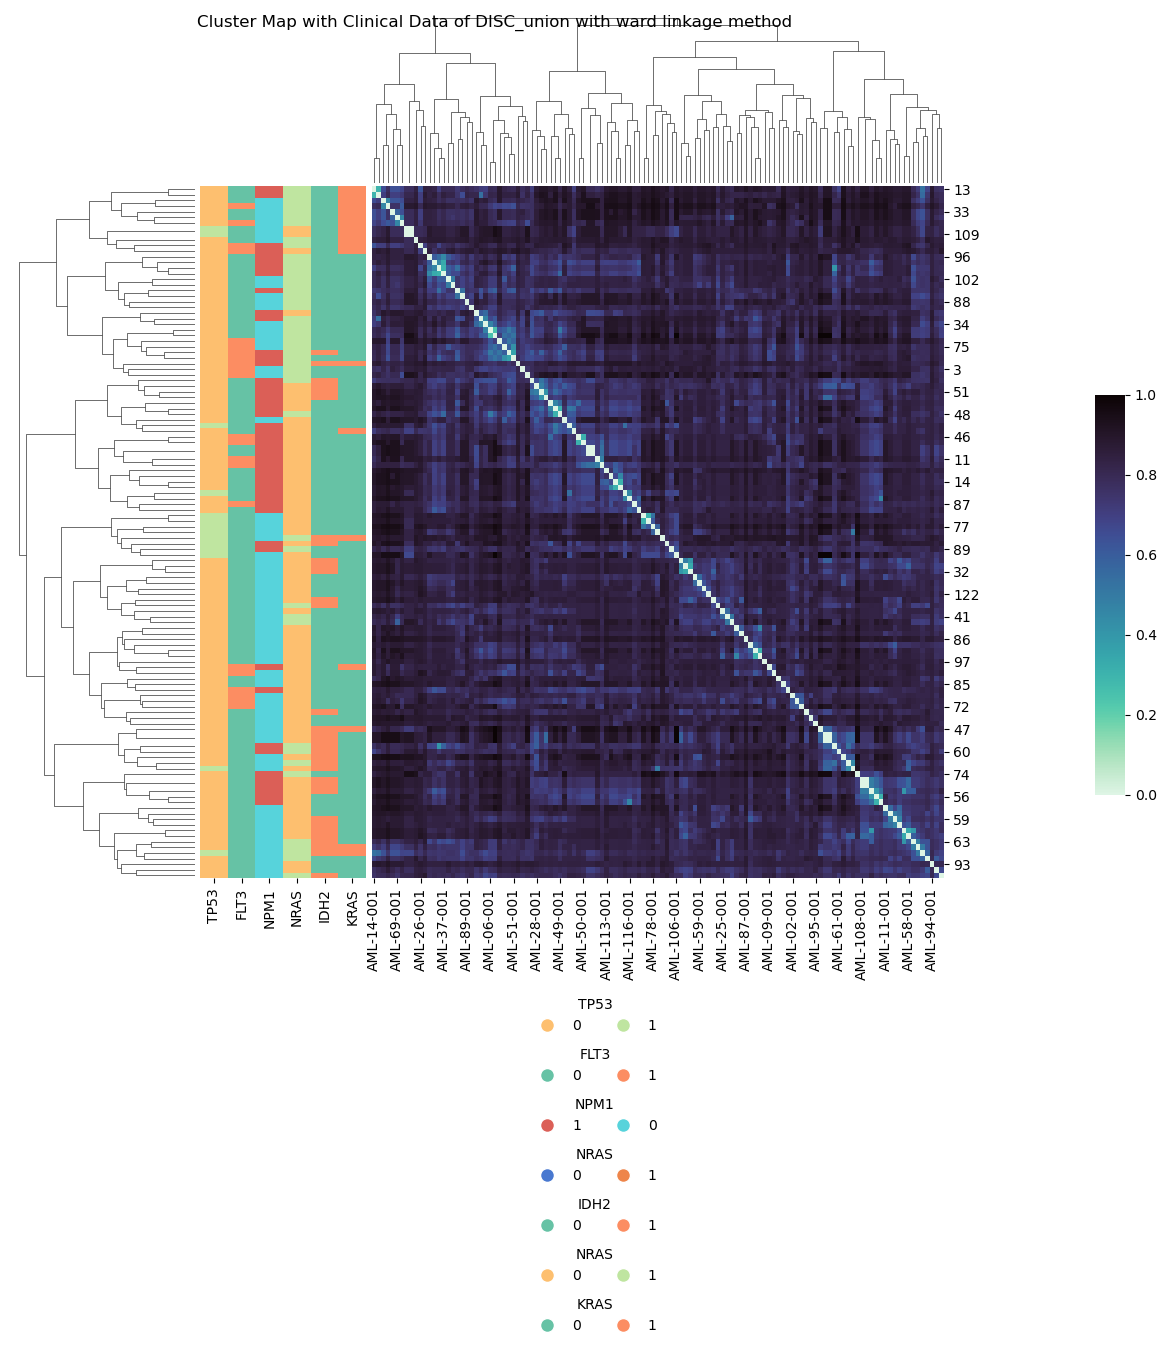

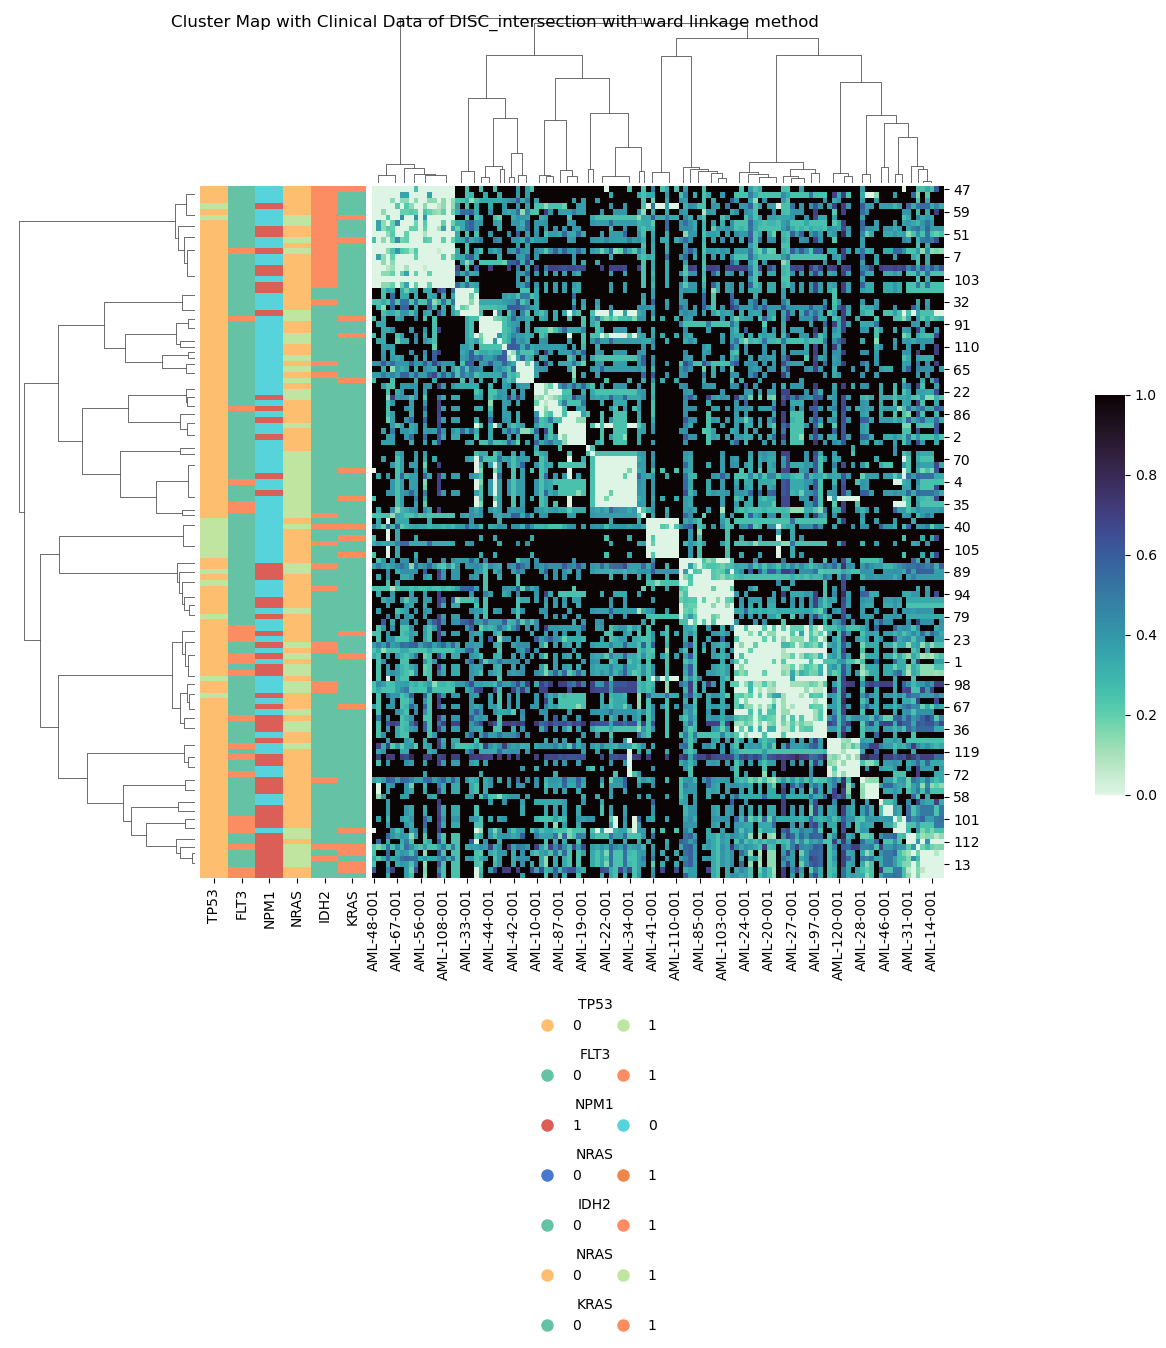

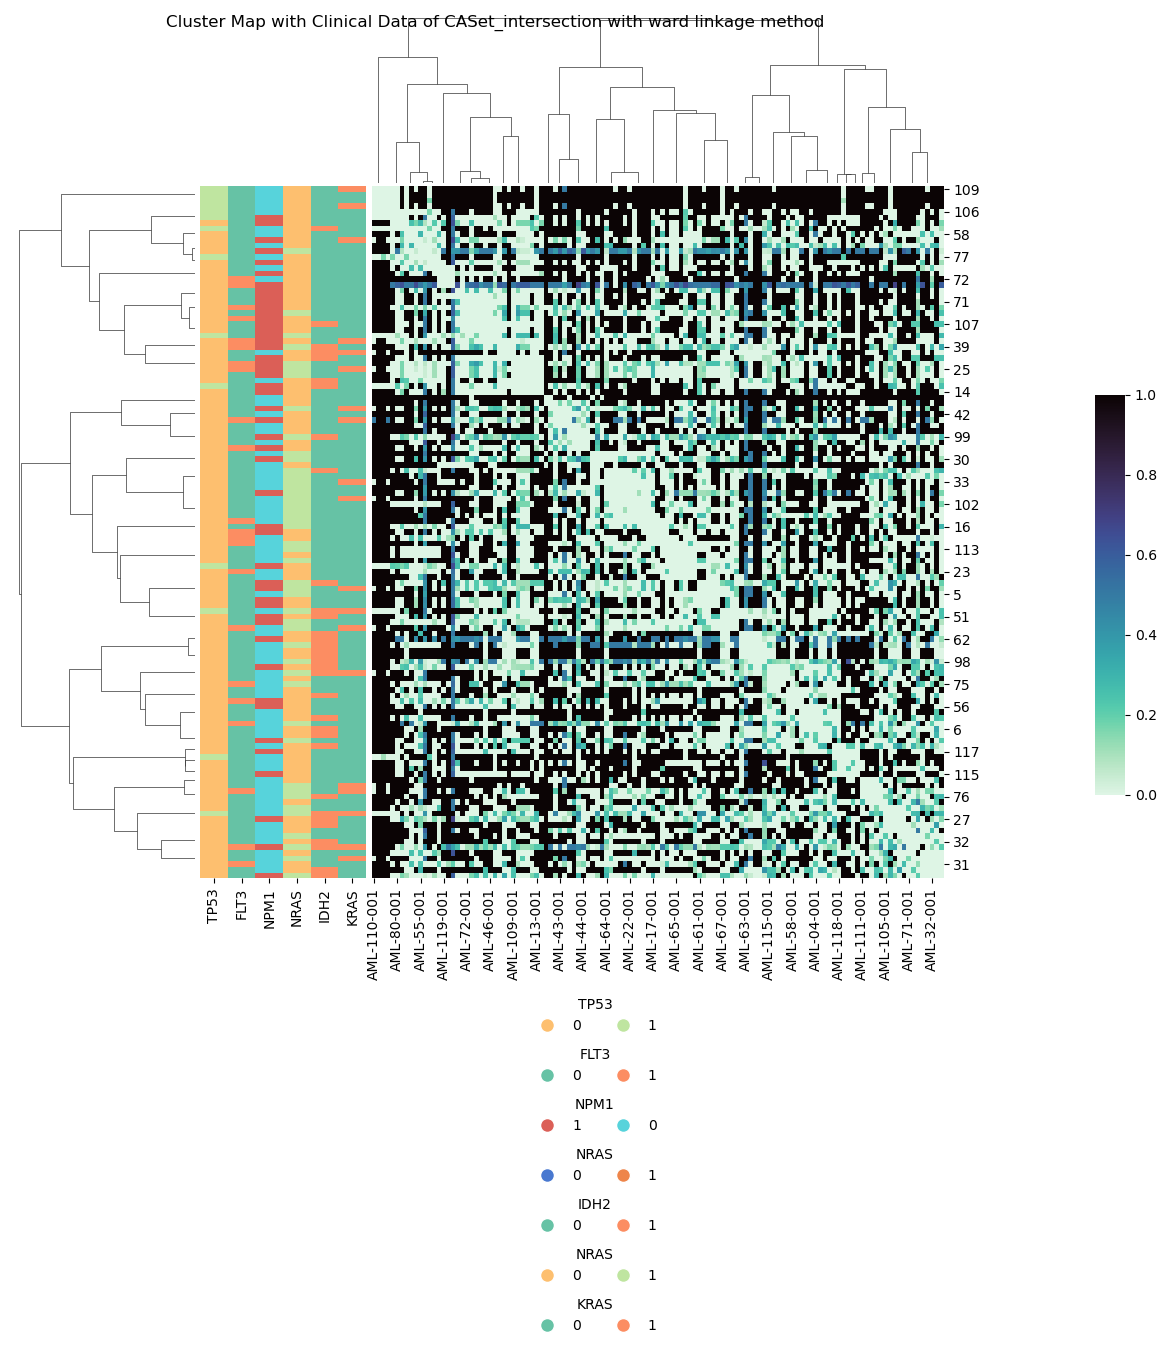

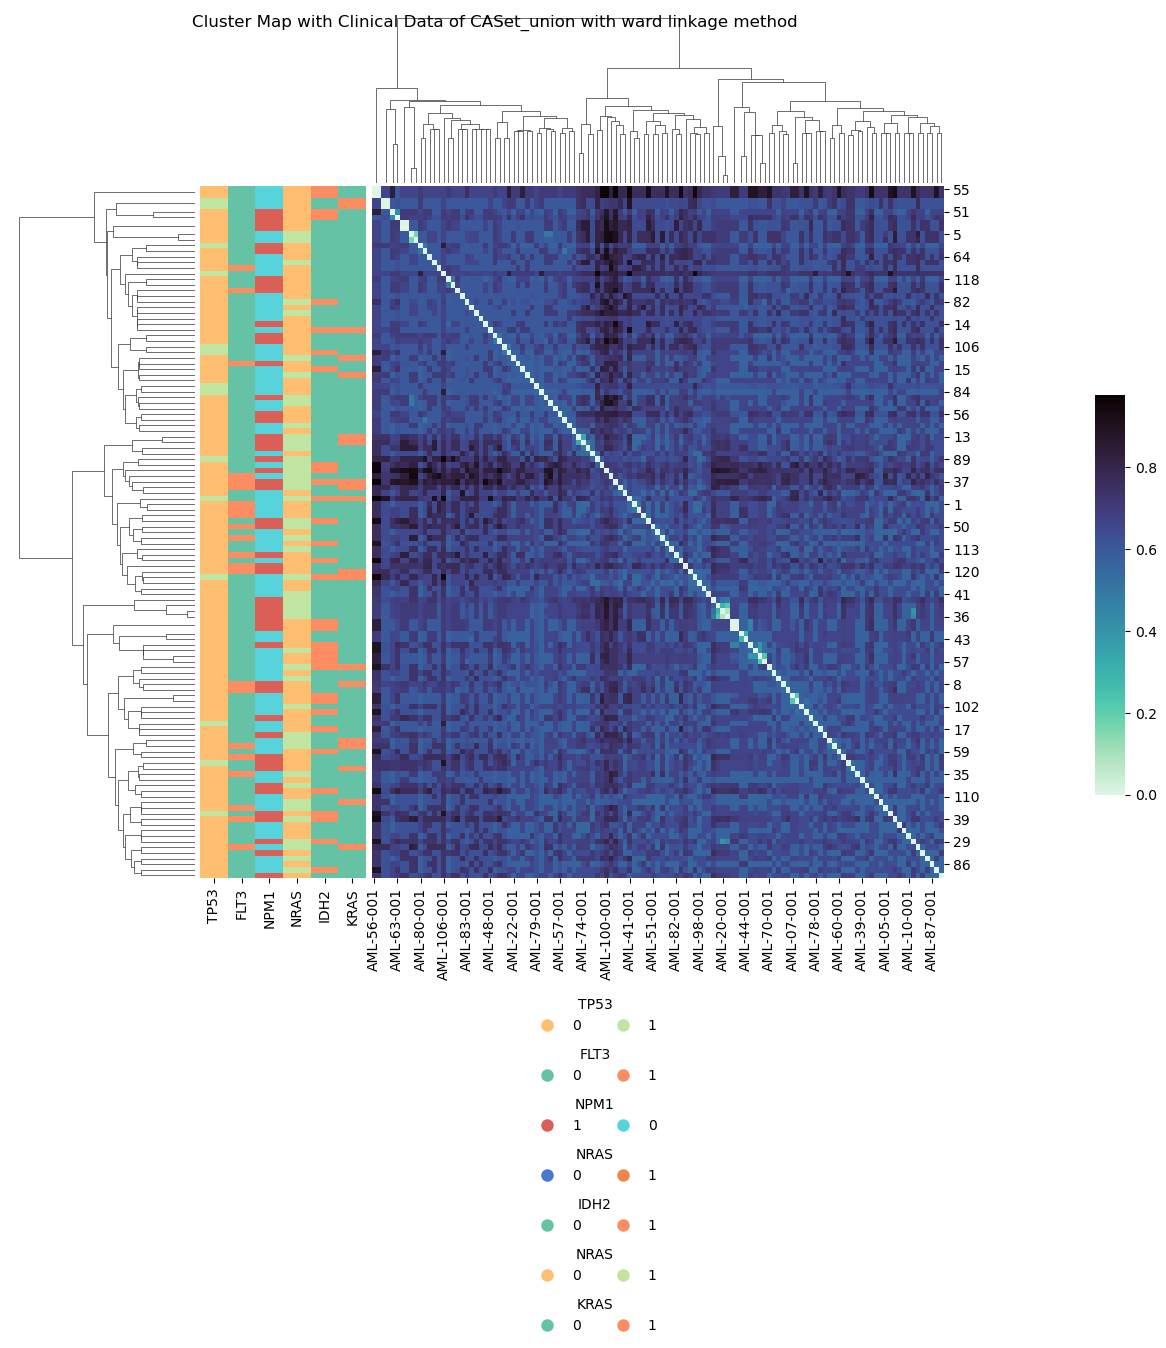

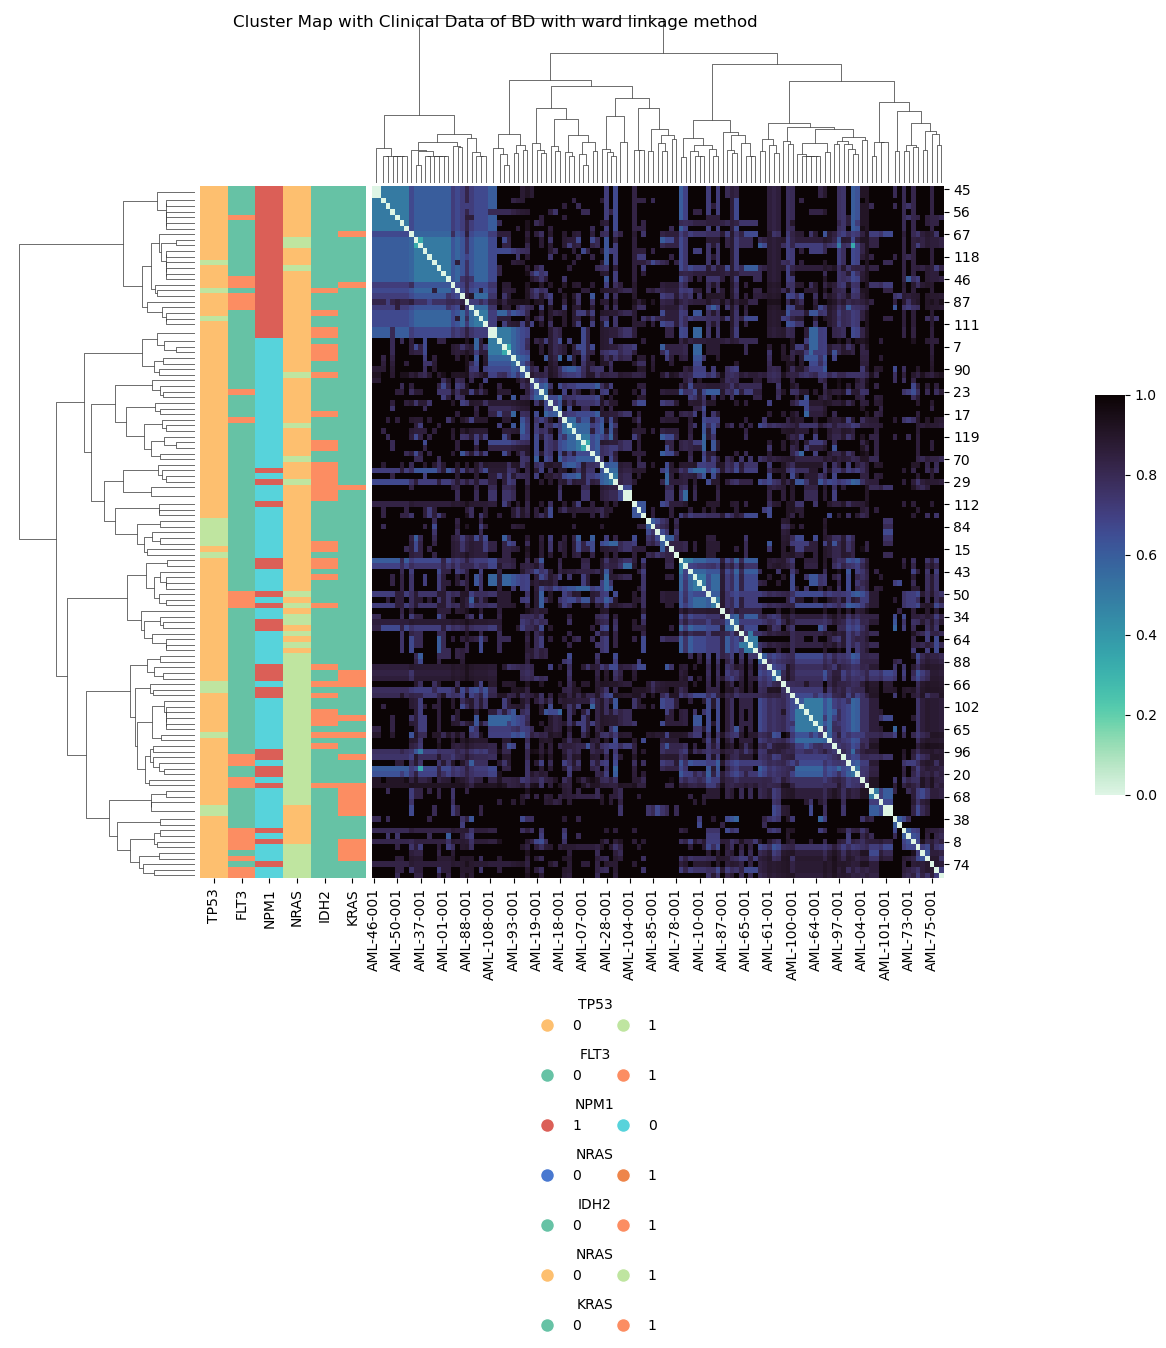

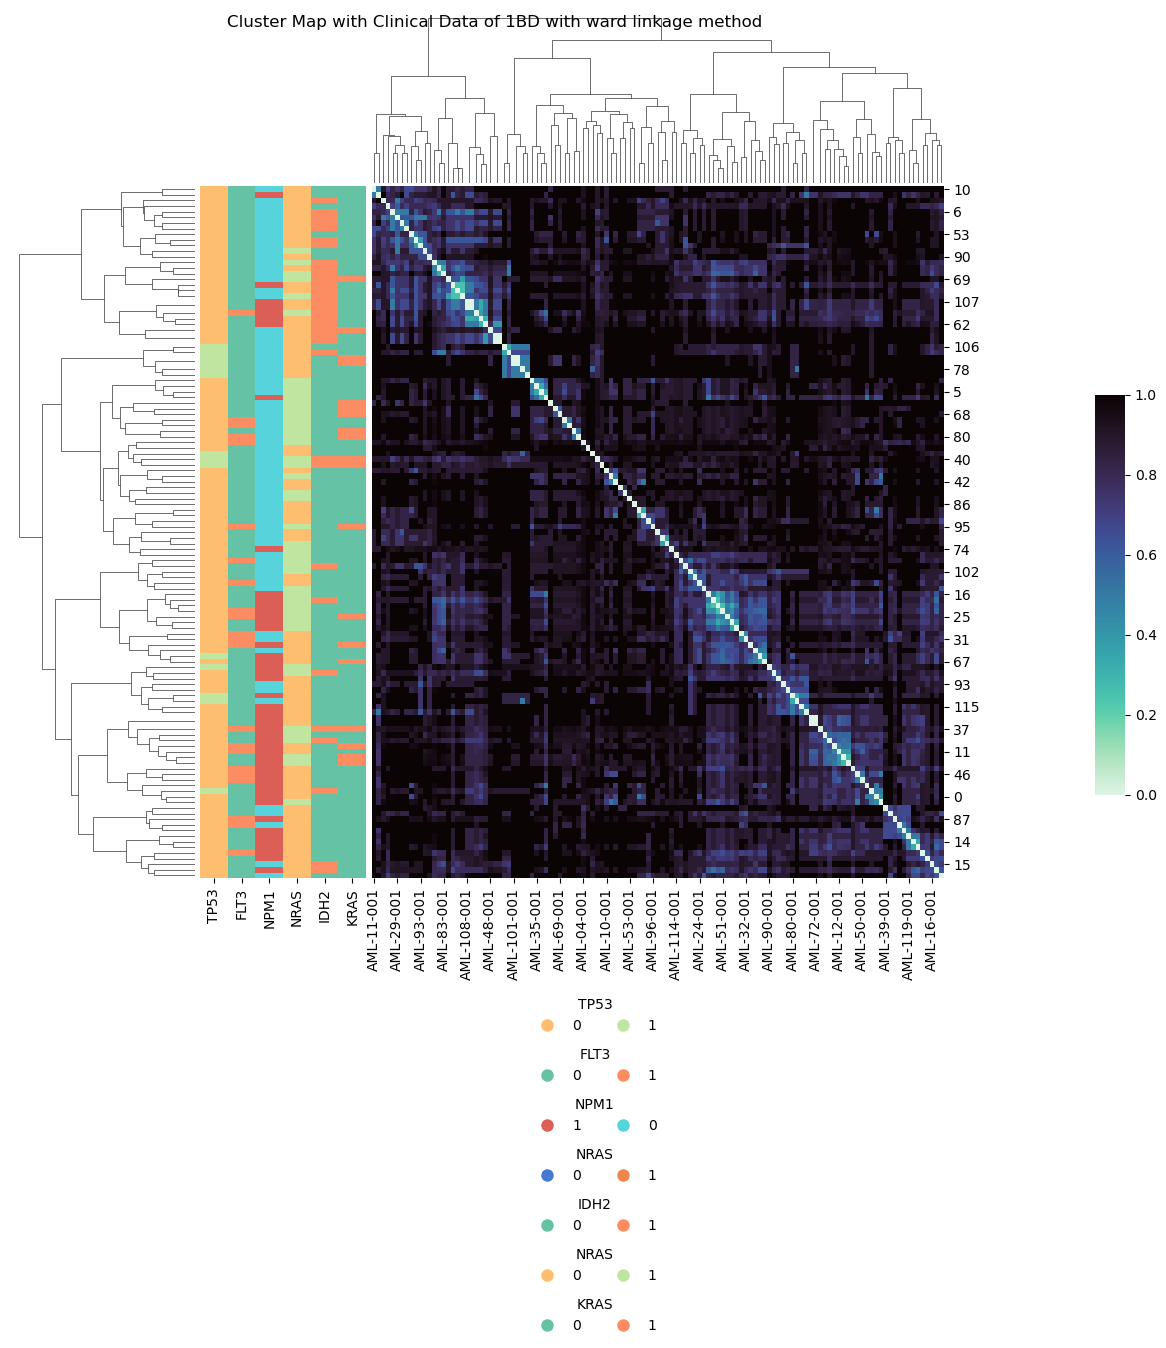

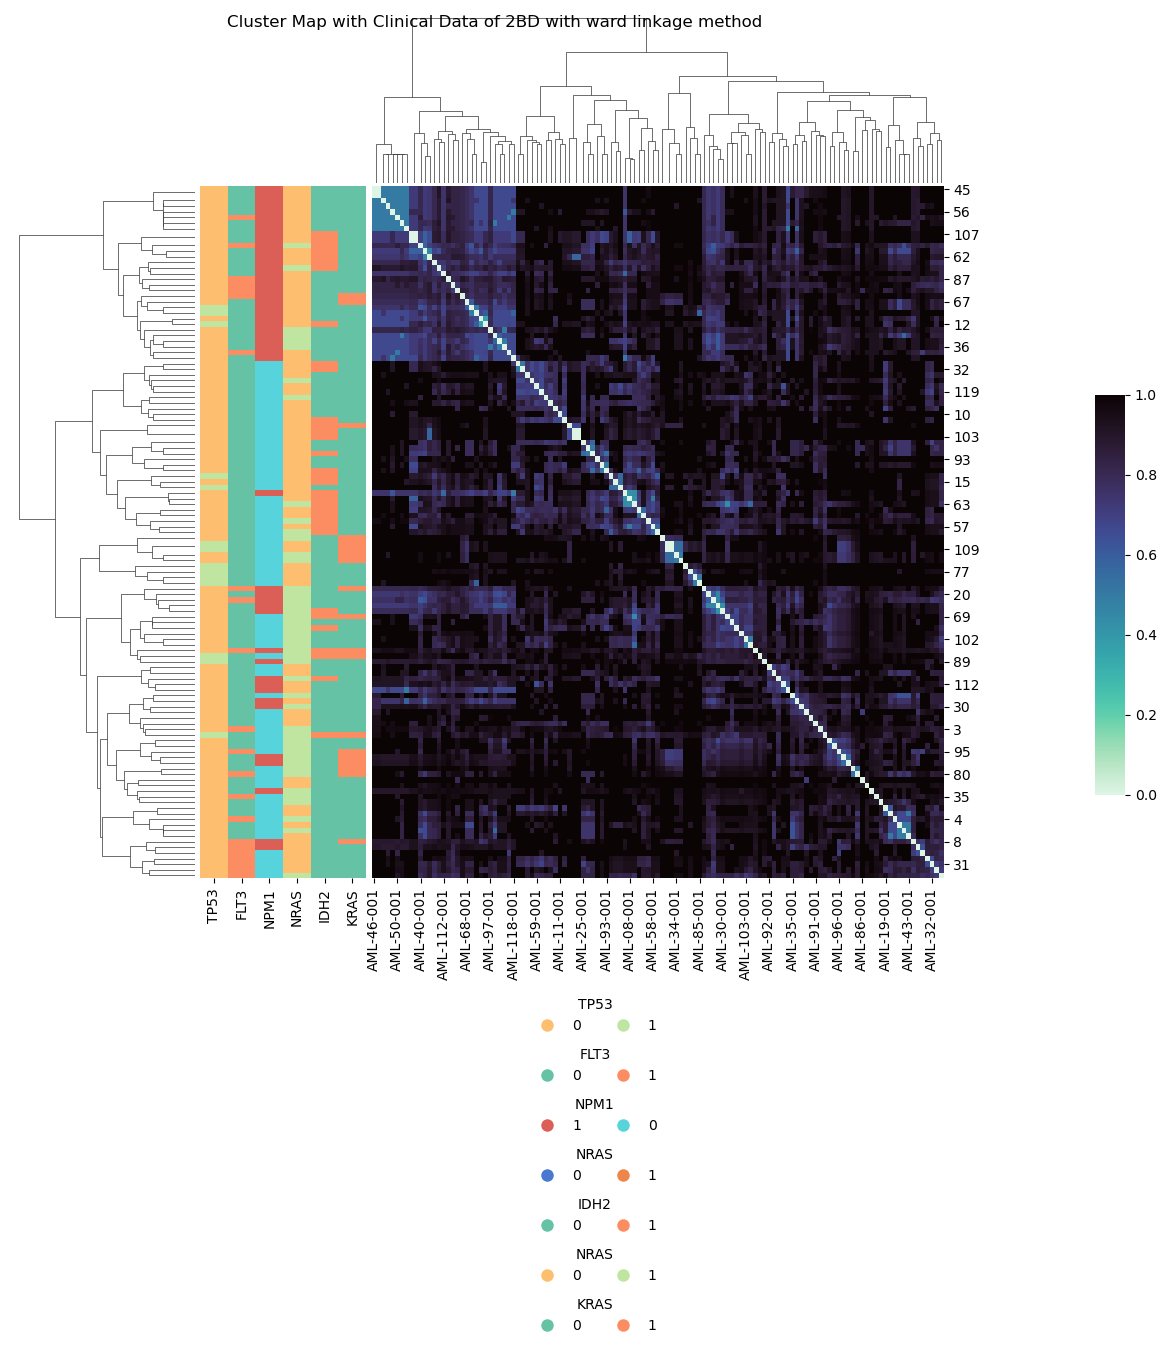

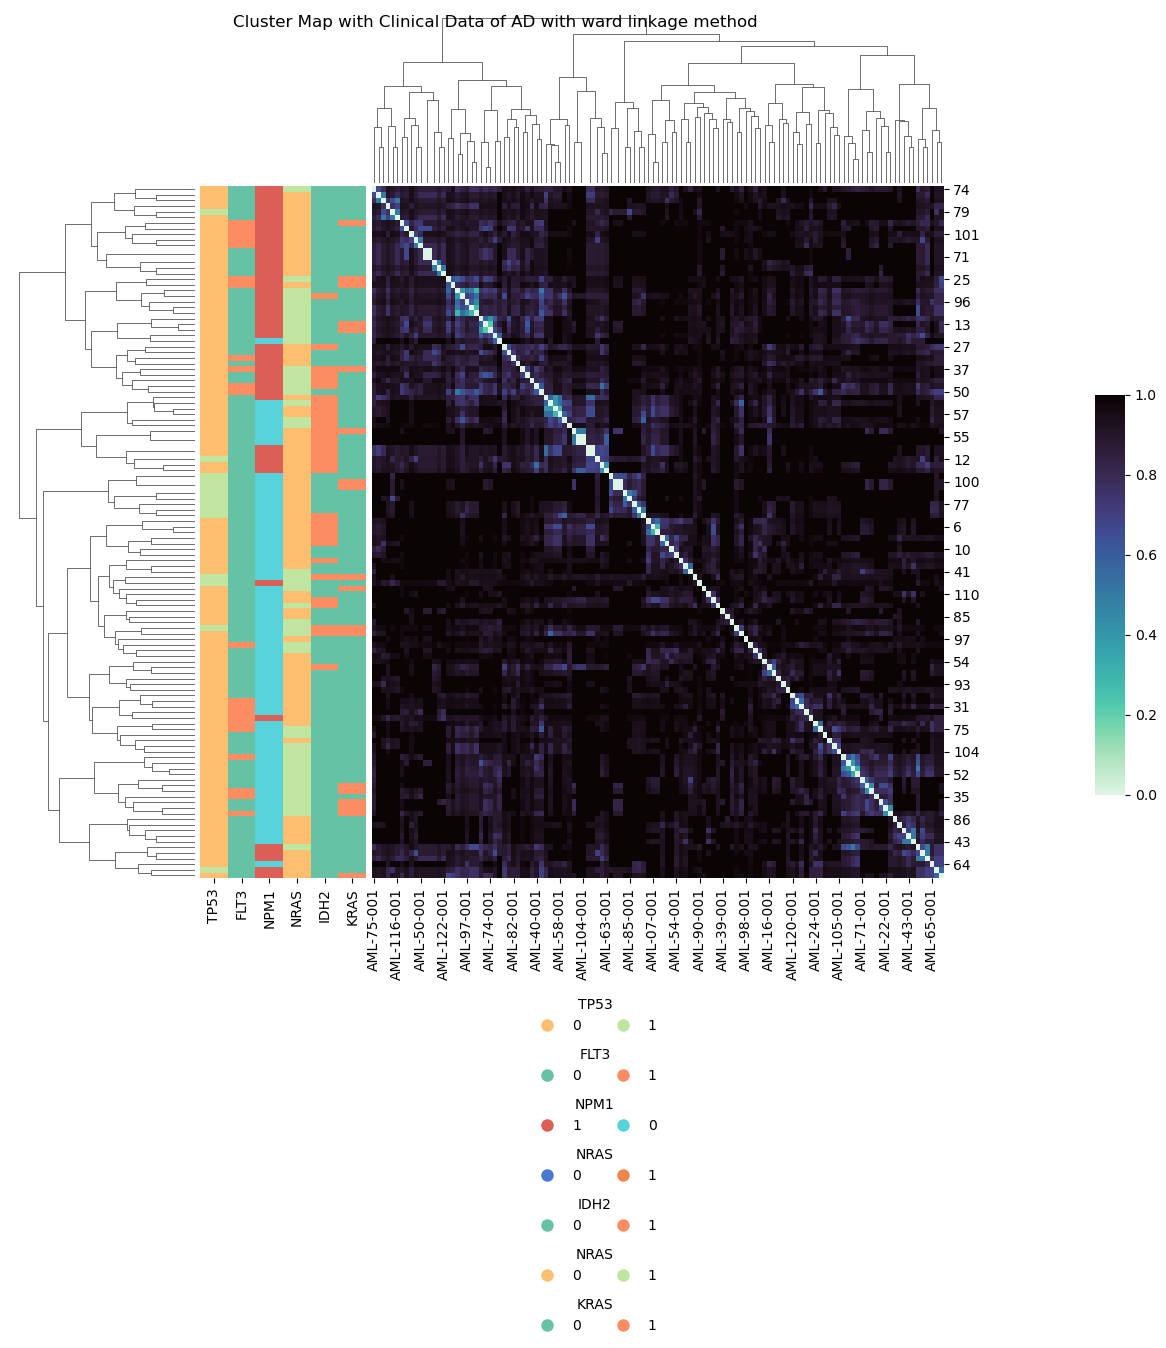

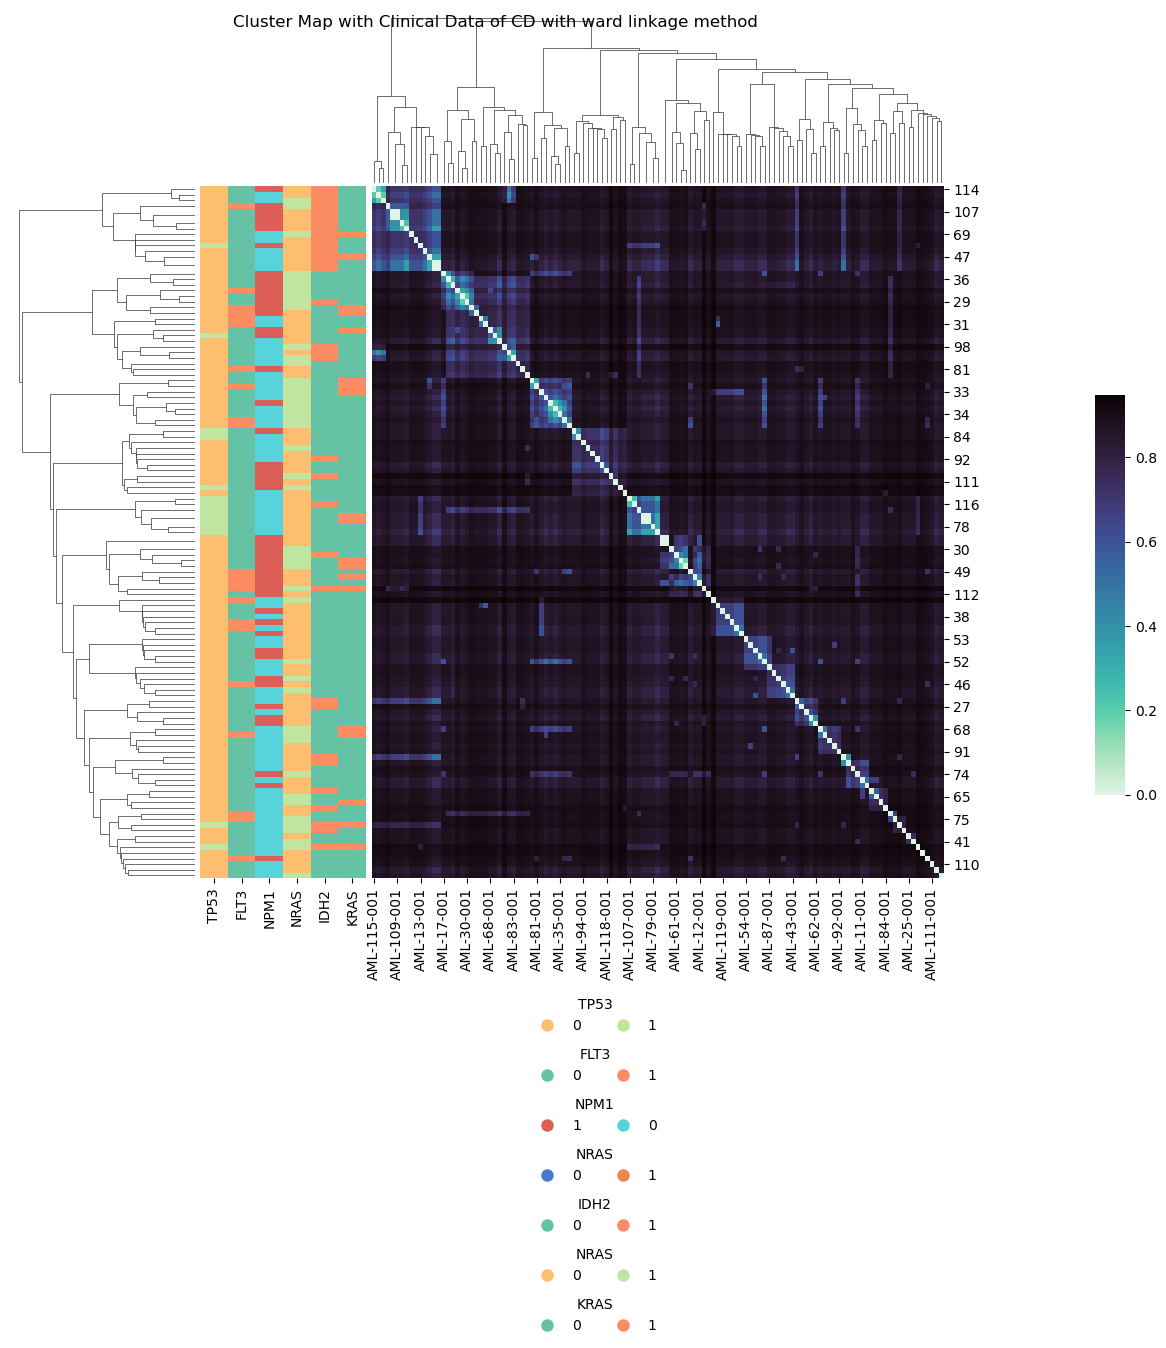

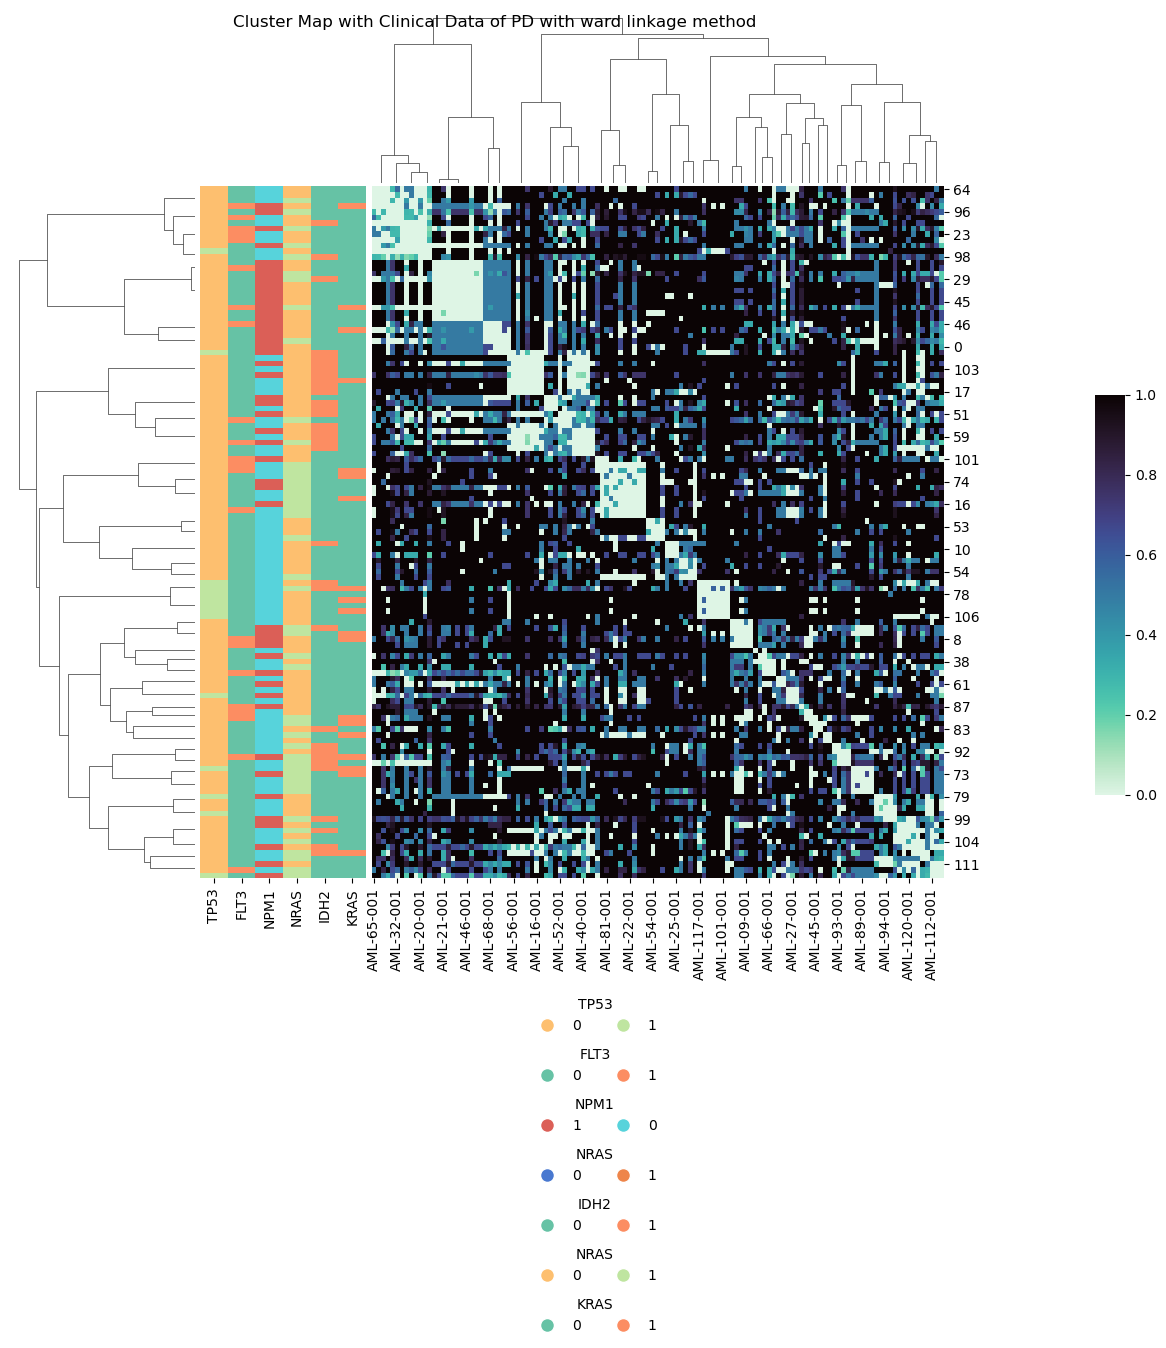

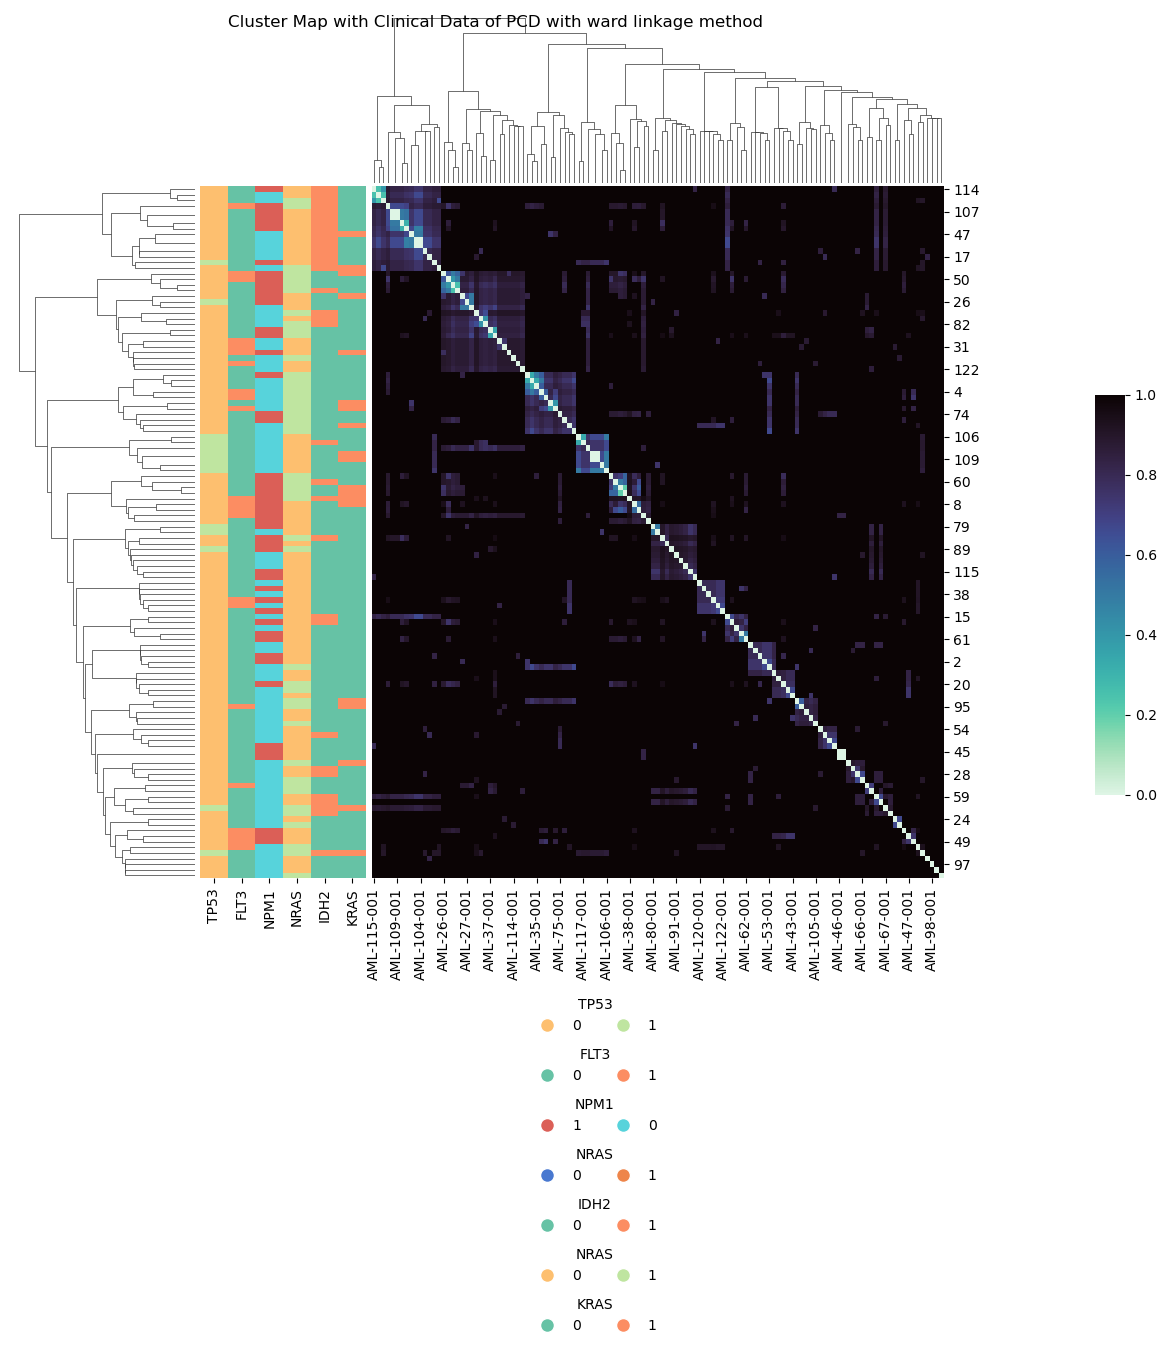

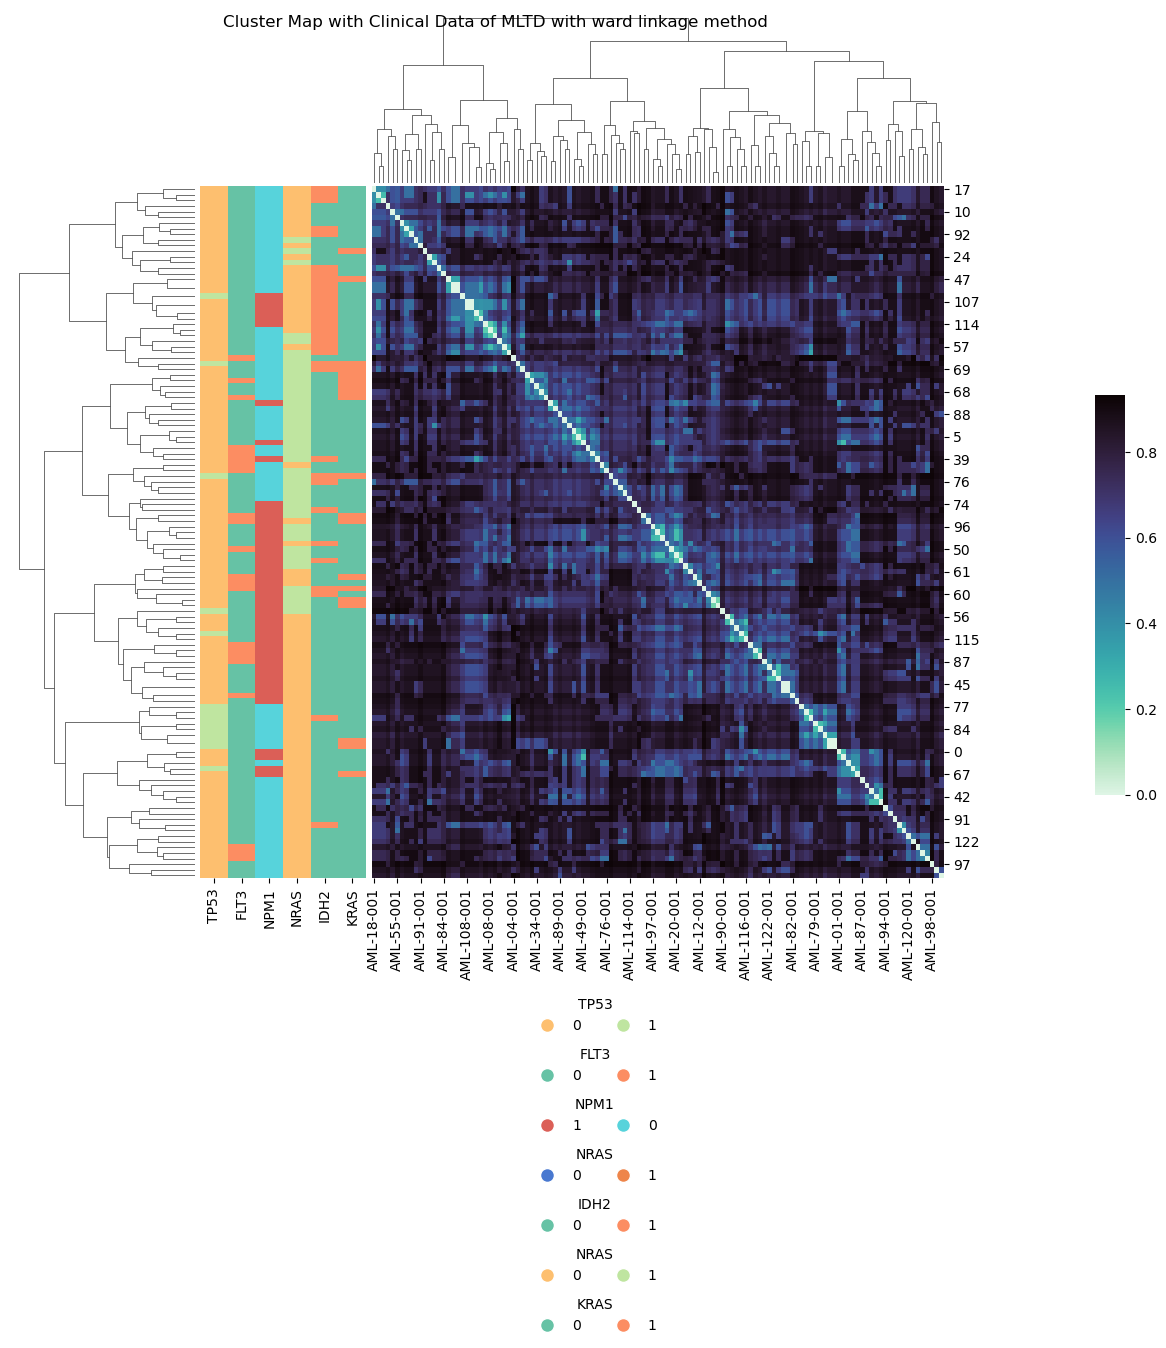

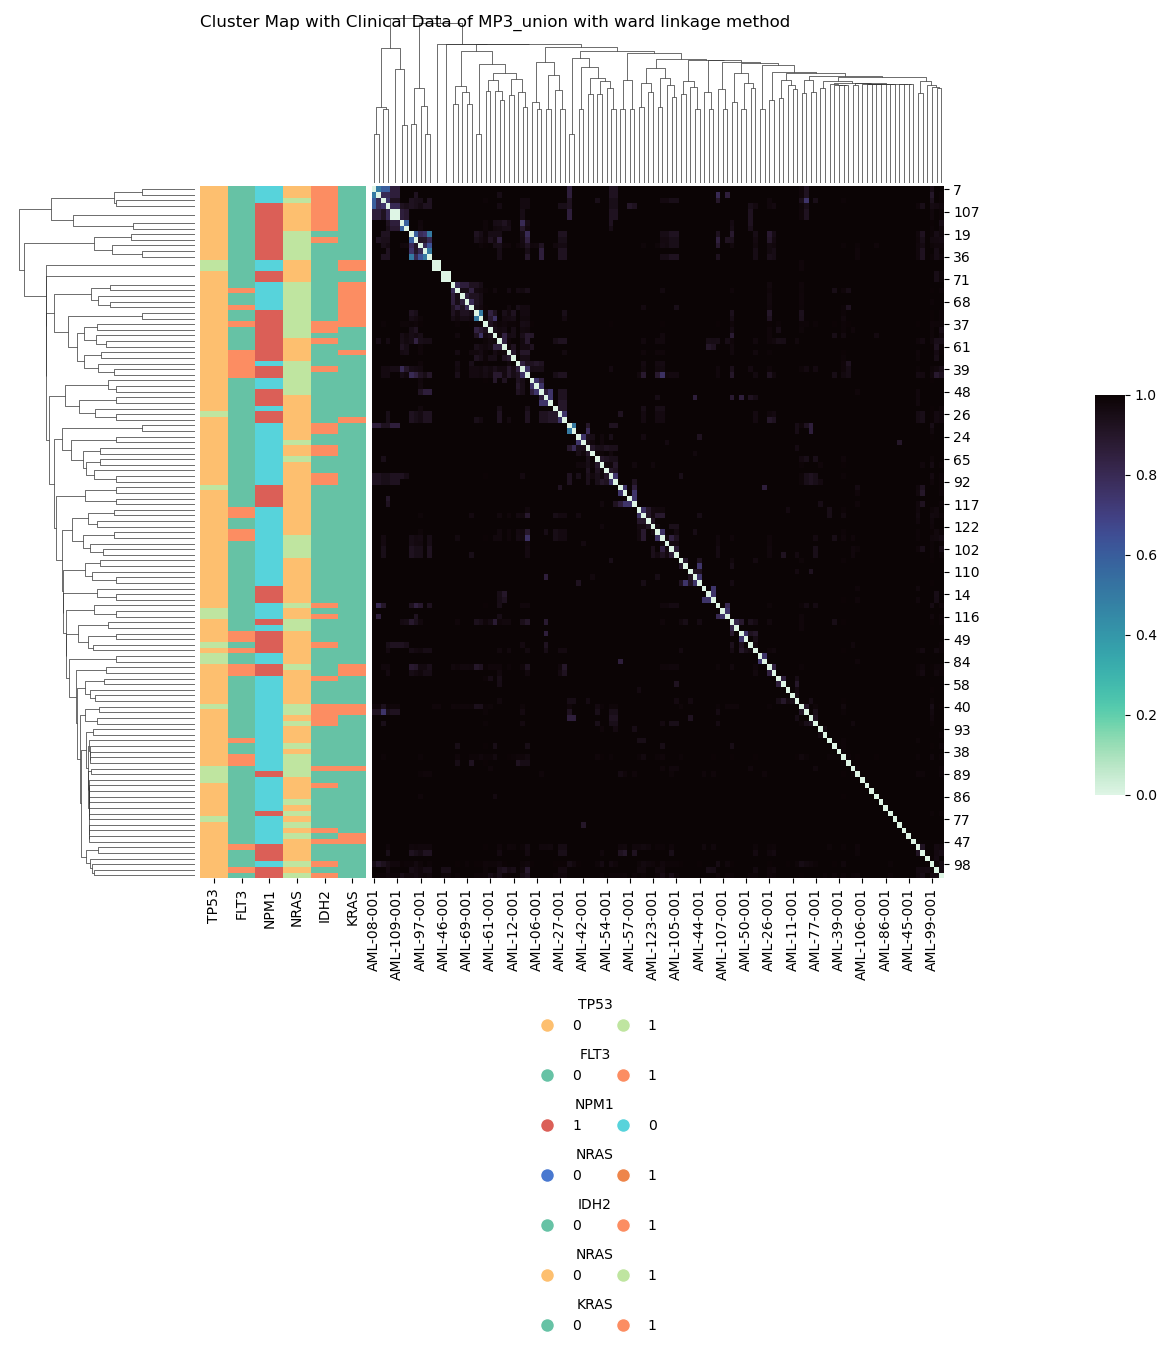

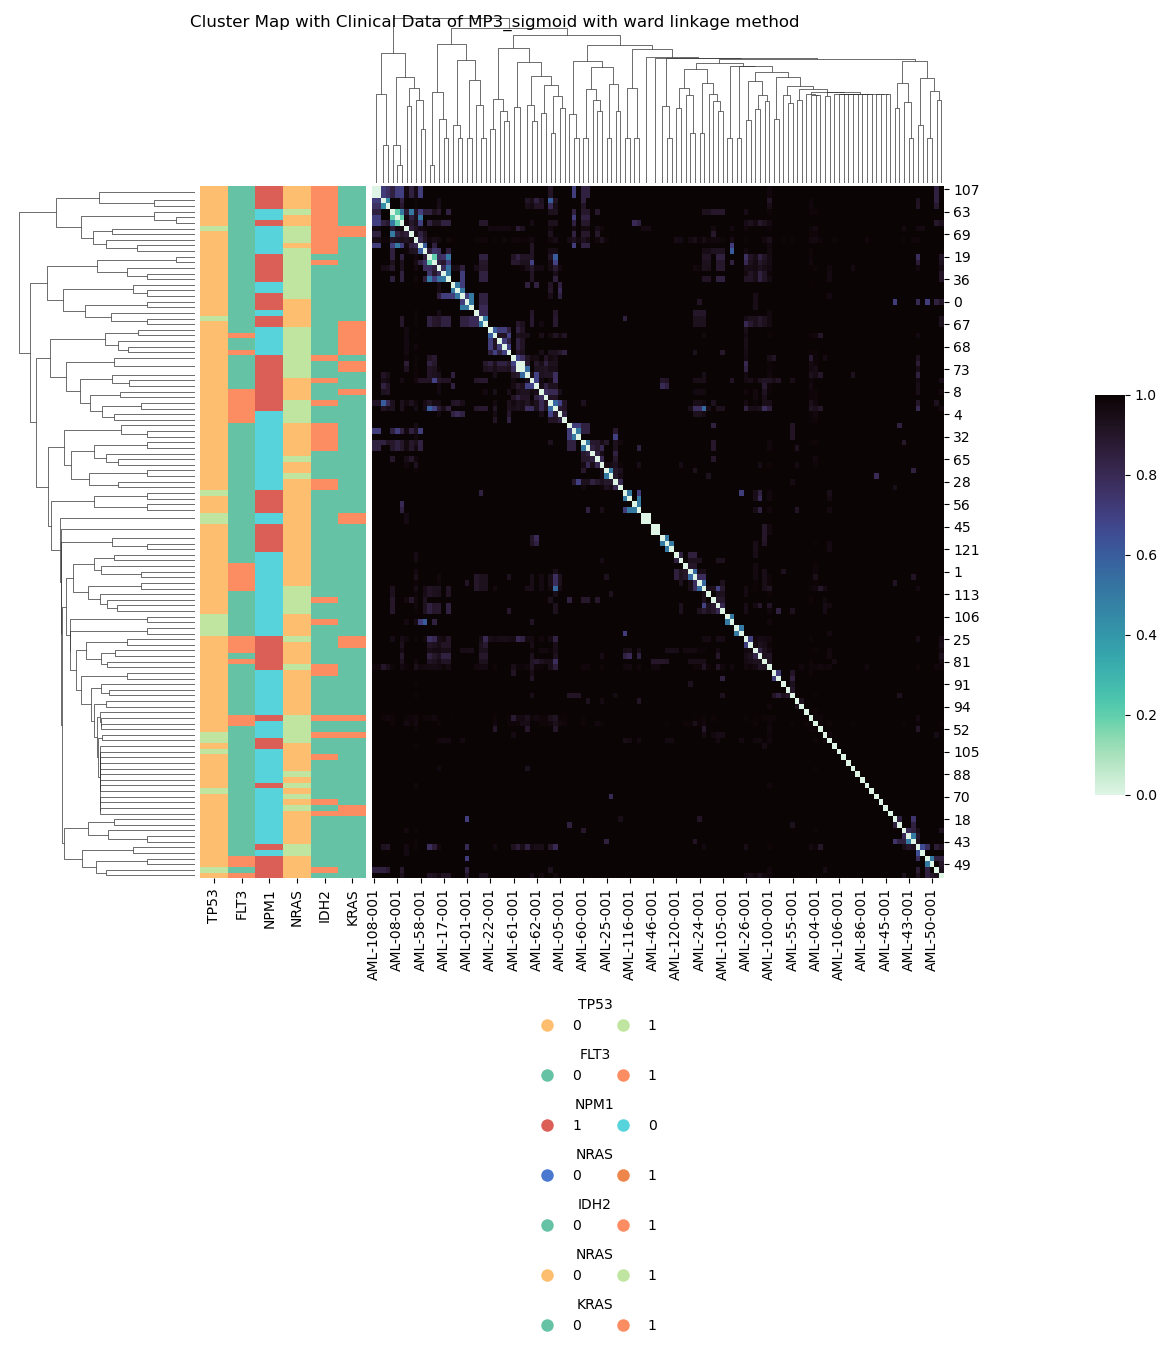

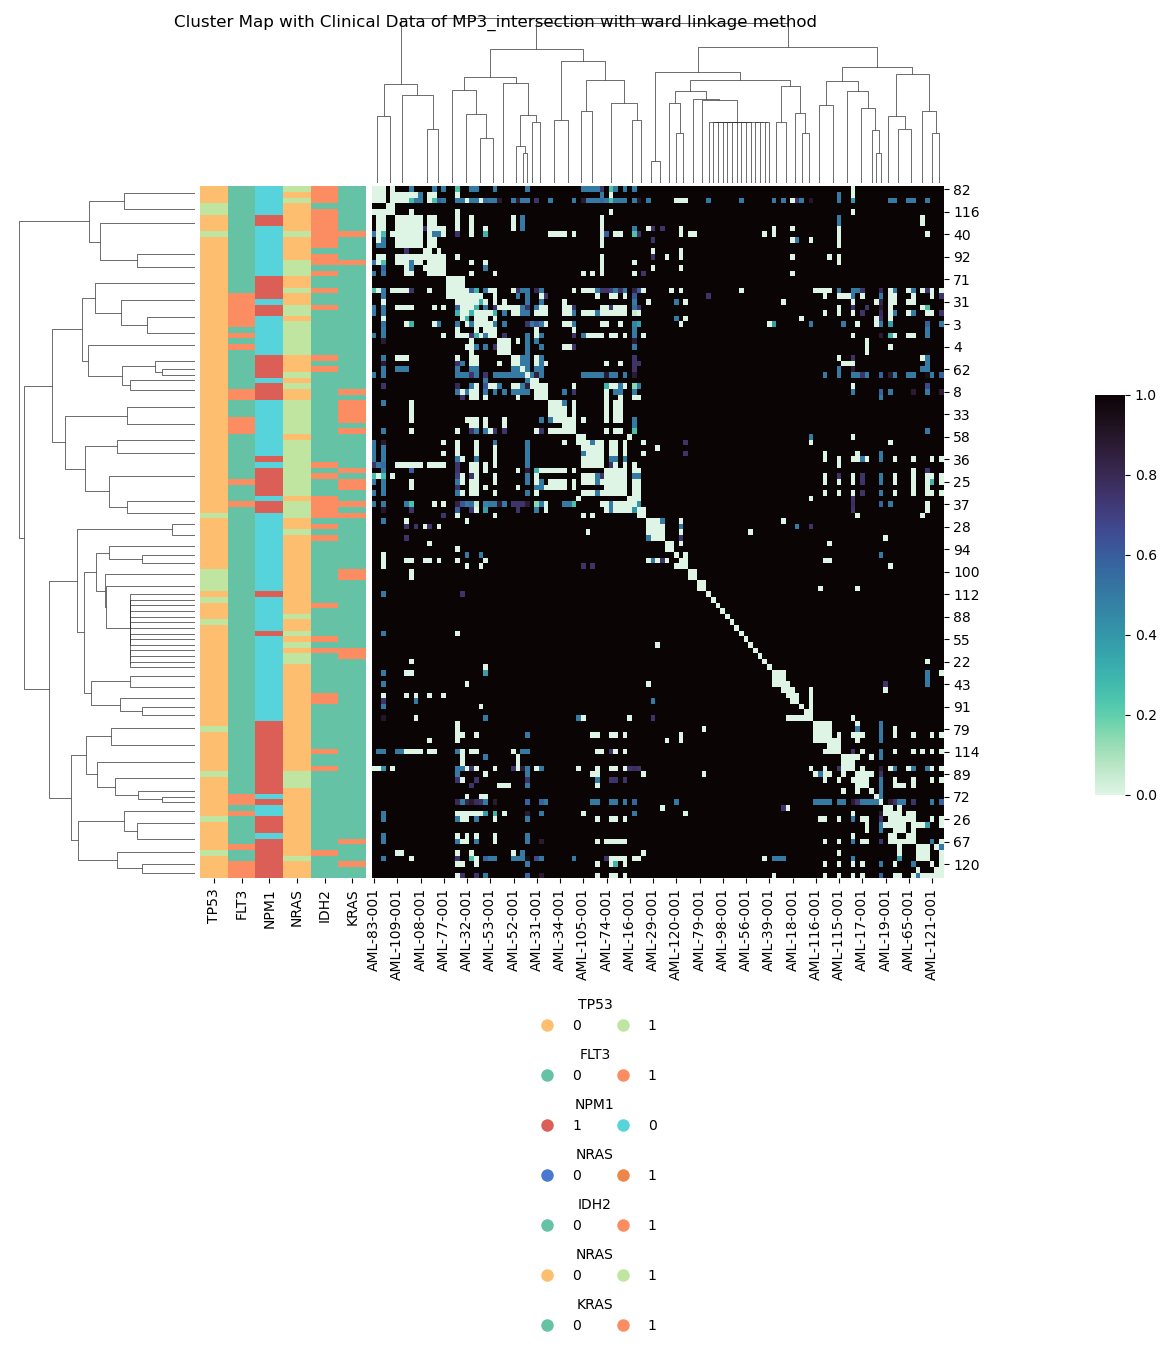

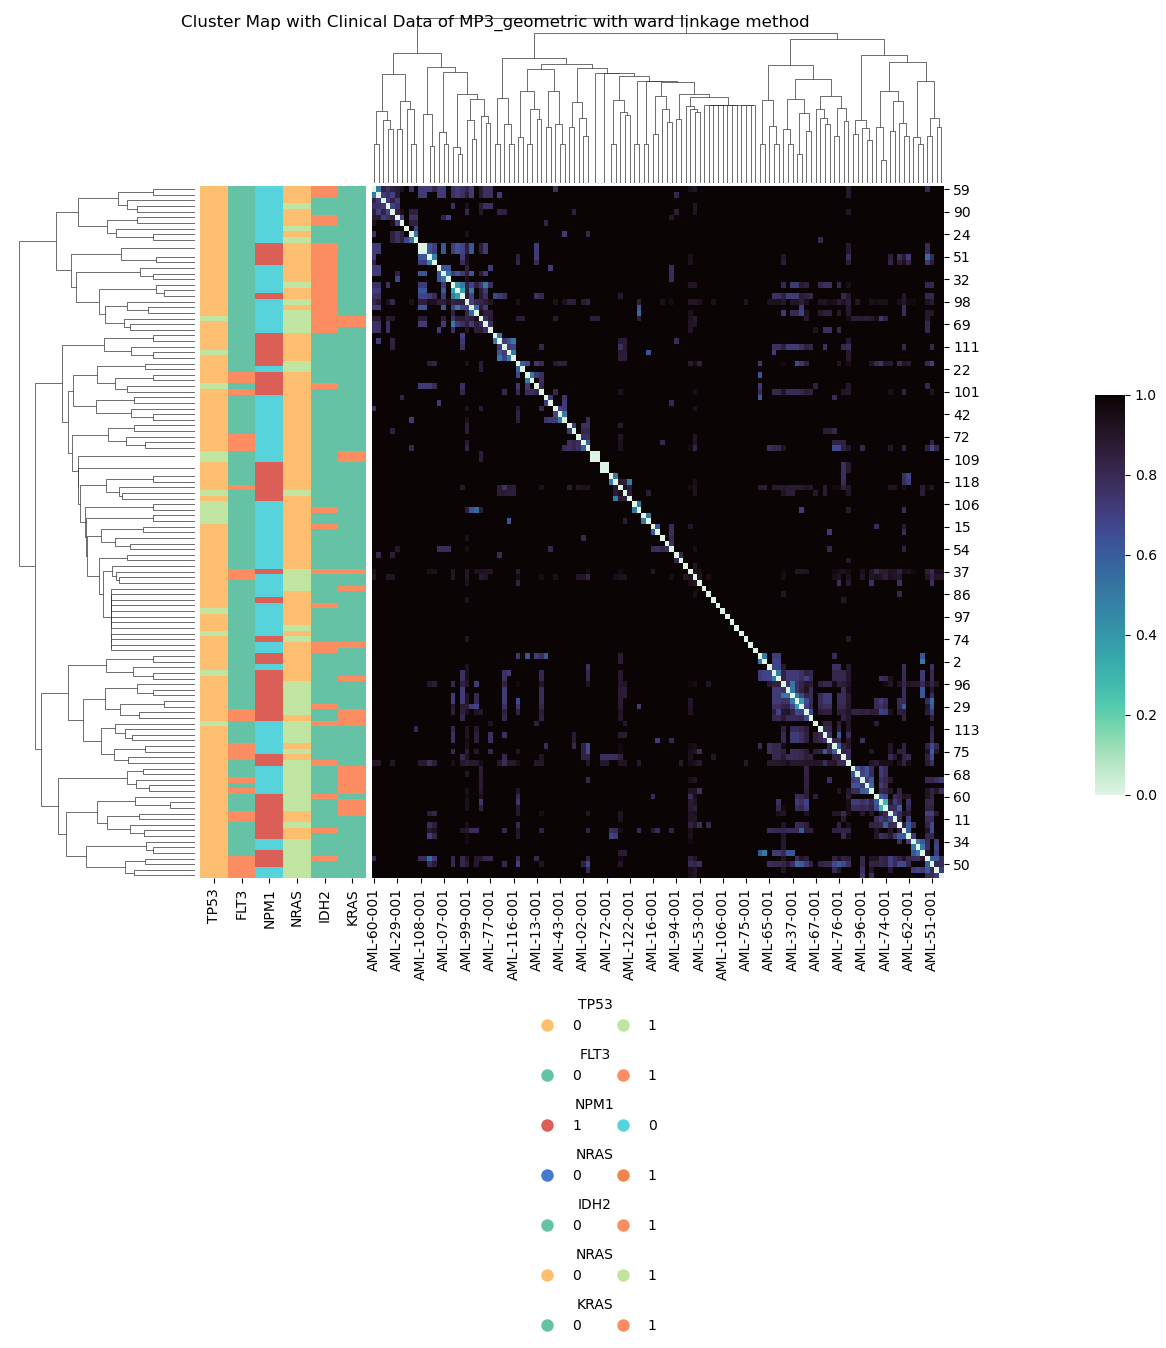

In [3]:
clinical_data = pd.read_csv(directory + '/' + thresh + '/clinicaldata_wclusterlabels.csv', delimiter=',')
for method in methods:
    data = pd.read_csv('Matrix Output/AML_'+method+'.csv', delimiter=',')

    clustermap_wMutations(data,method,clinical_data,'ward', 'GEN/Results/Clustermaps + Genotype/clustermap_wMutations_'+method+'.png')

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_correlation_network_jaccard_2(data_file, threshold_strong=0.9, threshold_normal=0.75, threshold_weak=0.6, color_node='skyblue', edge_label=False, output_dir=None):
    # Load the data
    df = pd.read_csv(data_file, index_col=0)

    # Create a graph from the dataframe
    G = nx.from_pandas_adjacency(df, create_using=nx.Graph)

    # Check if there are any edges in the graph
    if not G.edges():
        print("No edges in the graph!")
        return
    # Check if there are any edges above the weak threshold
    edges_above_threshold = [(node1, node2, weight['weight']) for node1, node2, weight in G.edges(data=True) if weight['weight'] >= threshold_weak]
    print(f"Edges above weak threshold: {edges_above_threshold}")

    # Define colors for nodes based on their connections
    color_map = []
    for node in G:
        # Check if the node has any edge stronger than or equal to the weak threshold
        has_stronger_edge = any(weight['weight'] >= threshold_weak for _, _, weight in G.edges(node, data=True))
        color_map.append(color_node if has_stronger_edge else 'lightgrey')

        # Print node color decision information
        if has_stronger_edge:
            print(f"Node {node} has an edge stronger than or equal to the weak threshold. Assigned color: {color_node}")
        else:
            print(f"Node {node} does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'")

    # Create a mask for your conditions
    mask_strong = np.abs(df.values) >= threshold_strong
    mask_normal = (np.abs(df.values) < threshold_strong) & (np.abs(df.values) >= threshold_normal)
    mask_weak = (np.abs(df.values) < threshold_normal) & (np.abs(df.values) >= threshold_weak)

    # Check if masks are correctly populated
    print(f"Strong edges: {np.sum(mask_strong)}")
    print(f"Normal edges: {np.sum(mask_normal)}")
    print(f"Weak edges: {np.sum(mask_weak)}")

    # Set node sizes and labels
    node_sizes = [3000 for _ in range(len(G))]  # Adjust node size as needed
    labels = {i: i for i in G.nodes()}  # Create labels dictionary

    # Define colors for nodes based on their connections
    
    # Create a figure to enable adjusting plot parameters
    fig, ax = plt.subplots(figsize=(12, 12))

    # Draw the nodes
    pos = nx.circular_layout(G)  # Try different layout like circular, kamada_kawai, etc.
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=color_map)

    # Draw the edges based on their weight
    for (node1, node2, data) in G.edges(data=True):
        weight = data['weight']
        if weight >= threshold_strong:
            # Draw strong edges
            nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)], width=2.5)
        elif weight >= threshold_normal:
            # Draw normal edges
            nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)], width=1, alpha=0.6)
        elif weight >= threshold_weak:
            # Draw weak edges
            nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)], style='dotted', alpha=0.4)

    if edge_label:
        edge_labels = {(n1, n2): round(d['weight'], 2) for n1, n2, d in G.edges(data=True) if d['weight'] > threshold_weak}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=13)
    # Draw labels
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    # Create a legend
    strong_line = mlines.Line2D([], [], color='black', linewidth=2.5, label=f'[{threshold_strong}, 1]')
    normal_line = mlines.Line2D([], [], color='black', linewidth=1, label=f'[{threshold_normal}, {threshold_strong}[', alpha=0.6)
    weak_line = mlines.Line2D([], [], color='black', linewidth=1, linestyle='dotted', label=f'[{threshold_weak},{threshold_normal}[', alpha=0.4)
    plt.legend(handles=[strong_line, normal_line, weak_line], loc='upper left')

    # Set margins and display the plot
    plt.margins(0.2)
    if output_dir is not None:
        plt.savefig(output_dir, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()


In [7]:
excel_1 = pd.read_excel(directory + '/' + thresh + '/Jacc_all.xlsx', sheet_name='only distances', index_col=0)
excel_1.to_csv(directory + '/' + thresh + '/Jaccard Index Clusters.csv', index=True)

Edges above weak threshold: [('CD', 'PCD', 0.885), ('CD', 'MP3_union', 0.657), ('CD', 'MP3_sigmoid', 0.632), ('PCD', 'MP3_union', 0.648), ('PCD', 'MP3_sigmoid', 0.624), ('MP3_union', 'MP3_sigmoid', 0.79)]
Node DISC_union does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'
Node DISC_intersection does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'
Node CASet_intersection does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'
Node CASet_union does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'
Node BD does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'
Node 1BD does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'
Node 2BD does not have edges stronger than or equal to the weak threshold. Assigned color: 'lightgrey'
Node AD does not have edges str

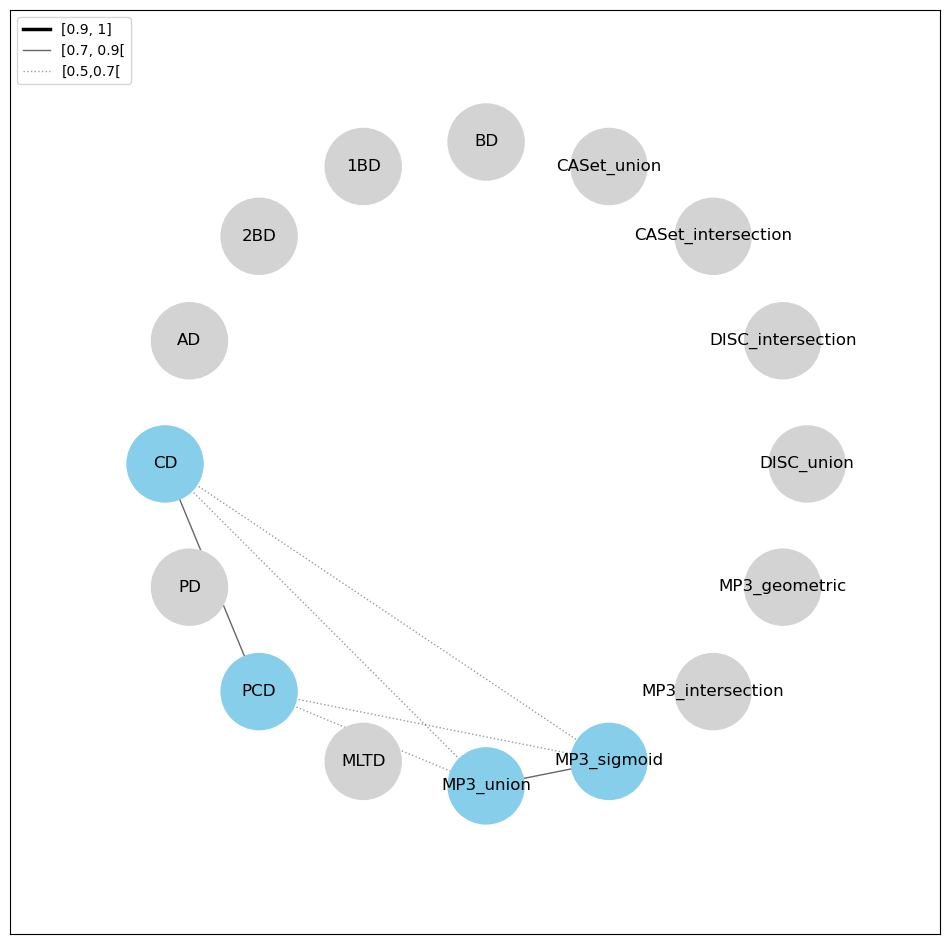

In [8]:
plot_correlation_network_jaccard_2(directory + '/' + thresh + '/Jaccard Index Clusters.csv',threshold_weak=0.5, threshold_normal=0.7,threshold_strong=0.9, output_dir=directory + '/' + thresh + '/' + stage + '/Jaccard Index Clusters.png', edge_label=False)


In [10]:
import pandas as pd

# Load the data
file_path = directory + '/' + thresh +'/clinicaldata_wclusterlabels.csv'

data = pd.read_csv(file_path)

In [11]:
# Identifying the columns for distance metrics and mutations
distance_metrics_columns = ['DISC_union', 'DISC_intersection', 'CASet_intersection', 'CASet_union', 'BD','1BD', '2BD', 'AD', 'CD', 'PD', 'PCD', 'MLTD', 'MP3_union', 'MP3_sigmoid', 'MP3_intersection', 'MP3_geometric']
mut = pd.read_csv('GEN/Results/survival/t = 0.02/covariates_gene.csv', delimiter=',')
mutations_columns = mut['gene'].tolist()

# We'll store the results in a dictionary for each distance metric
clusters_mutations = {col: {} for col in distance_metrics_columns}

# Calculating mutation frequencies for each cluster in each distance metric
for metric in distance_metrics_columns:
    # For each unique cluster in the distance metric
    for cluster in data[metric].unique():
        cluster_data = data[data[metric] == cluster]
        total_patients = len(cluster_data)

        # For each mutation, calculate the frequency in the current cluster
        mutation_frequencies = {}
        for mutation in mutations_columns:
            mutation_count = cluster_data[mutation].sum()
            mutation_frequency = mutation_count / total_patients

            # If the mutation frequency is 50% or more, we keep it
            if mutation_frequency >= 0.5:
                mutation_frequencies[mutation] = mutation_frequency

        # Storing mutation frequencies for the current cluster
        clusters_mutations[metric][cluster] = mutation_frequencies

# Checking the structure of the resulting dictionary for the first distance metric
dict(list(clusters_mutations.items())[0:1])  # Displaying just the first item for brevity

{'DISC_union': {0: {'NPM1': 0.9583333333333334},
  1: {},
  2: {'NRAS': 0.8823529411764706}}}

In [12]:
# Using the 'Set2' color palette from seaborn for better distinction
import seaborn as sns
# Update plot function to enhance visibility and formatting
def enhanced_plot_stacked_bar(data, series_labels, category_labels=None, 
                              show_values=False, value_format="{}", y_label=None, 
                              colors=None, grid=False, reverse=False):

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                if h > 0:  # Only show label if height (percentage) is greater than 0
                    plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                             value_format.format(h), ha="center", 
                             va="center", fontsize=9, fontweight='bold')
                    
    plt.grid(False, axis='x')


# Get a color palette from seaborn




In [14]:
for metric in distance_metrics_columns:
    clusters_data = clusters_mutations[metric]
    clusters = sorted(clusters_data.keys())
    mutations = sorted(list(set(mutation for cluster_data in clusters_data.values() for mutation in cluster_data.keys())))

    # Skip plotting if there are no mutations for this metric
    if not mutations:
        continue

    # Regenerate the color palette based on the number of mutations for the current metric
    color_palette = sns.color_palette("Set2", len(mutations), desat=0.8)
    

    # Prepare data for plotting
    plot_data = []
    for mutation in mutations:
        mutation_data = []
        for cluster in clusters:
            mutation_data.append(clusters_data[cluster].get(mutation, 0))
        plot_data.append(mutation_data)

    # Convert data to percentage for plotting
    plot_data_percentage = [np.array(dat) * 100 for dat in plot_data]

    # Create a new figure for each plot

    plt.figure(figsize=(15, 7))
    enhanced_plot_stacked_bar(
        plot_data_percentage, 
        series_labels=mutations, 
        category_labels=[f"Cluster {cluster}" for cluster in clusters],
        show_values=True, 
        value_format="{:.1f}%",  # No more 0.0% and also makes text bold
        y_label="Percentage of Patients with the Mutation",
        colors=color_palette
    )
    plt.title(f"Mutation Distribution Across Clusters ({metric})")
    plt.yticks([])  # Remove y-axis ticks
    
    # Save the figure
    plot_path = directory + f"/{thresh}/Mutation bar plot/{metric}_plot.png"
    plt.savefig(plot_path, bbox_inches='tight', dpi = 300)
    plt.close()  # Close the figure to free up memory

    # Store the path of the saved plot
